# Relative quantification proof of concept

Take a first pass at implementing evaluation of (fractional) relative quantification, more or less following [Joseph's blueprint](https://docs.google.com/document/d/1u18BSWB2776d-EXAoft7Je5KmhC1aGMFZJRpJ1rueNI/edit) with a [few practical pointers I had come up with](https://docs.google.com/document/d/1t30SEHZ6RSFYXG7o1ylWCfgYWVbZCA1jj-SkES1M2rw/edit)

Purpose isn't to necessarily to make something fully flexible/ready to go, but to explore how to implement the blueprint and understand any impacts our filtering criteria/decisions may have.


Broadly, this involves:
- Defining list of genes expressed above a given TPM threshold from RNA-seq data
- Defining a set of terminal exons w/ 2 polyA sites from the GT poly(A) site BEDs, filtering to 2 most expressed sites if a TE has > 2 PAS
- Filtering the predicted sites to those occurring on curated set of terminal exons
- 


Will focus on a single Mayr sample Mayr_CD5B_R3 with outputs from DaPars2 & DaPars for now...

In [1]:
import pyranges as pr
import pandas as pd
import numpy as np
import os
import warnings

# There are some FutureWarnings with installed version of PyRanges and Pandas - For visual purposes just don't print them for now
warnings.filterwarnings('ignore')

# 1. Find genes expressed in RNA-seq above a given threshold


Matt provided a TSV of Salmon quantification outputs from the nf-core RNA-seq workflow (**TODO: insert link**). As this is per-transcript, need to sum to gene-level

Target is a list/set of Ensembl gene IDs that pass a given TPM threshold

In [2]:
tpm_df = pd.read_csv("data/Mayr_salmon.merged.transcript_tpm.tsv", sep="\t")
tpm_df.head(n=10)

,tx,gene_id,Mayr_CD5B_R3,Mayr_CD5B_R4,Mayr_GC_R1,Mayr_GC_R2,Mayr_GC_R3,Mayr_GC_R4,Mayr_M_R2,Mayr_M_R6,Mayr_NB_R1,Mayr_NB_R2,Mayr_NB_R3,Mayr_NB_R4,Mayr_NB_R5,Mayr_NB_R6
0,ENST00000456328.2,ENSG00000223972.5,0.00000,0.044865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.135770,0.012529,0.000000,0.000000,0.000000,0.00000
1,ENST00000450305.2,ENSG00000223972.5,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,ENST00000488147.1,ENSG00000227232.5,2.62799,3.314172,2.877079,2.625817,2.839663,3.452287,2.285098,2.630034,2.627121,2.015704,2.529293,1.699014,2.747853,2.22484
3,ENST00000619216.1,ENSG00000278267.1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,ENST00000473358.1,ENSG00000243485.5,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
5,ENST00000469289.1,ENSG00000243485.5,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.03989
6,ENST00000607096.1,ENSG00000284332.1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
7,ENST00000417324.1,ENSG00000237613.2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
8,ENST00000461467.1,ENSG00000237613.2,0.00000,0.000000,0.000000,0.026530,0.000000,0.000000,0.030134,0.000000,0.000000,0.000000,0.026825,0.000000,0.000000,0.00000
9,ENST00000606857.1,ENSG00000268020.3,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073951,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [3]:
# Summarise individual transcript expression to gene-level TPM
sample_cols = [col for col in tpm_df.columns if col not in ["tx", "gene_id"]]
# sample_cols

gene_tpm = tpm_df.groupby("gene_id")[sample_cols].sum()
gene_tpm

,Mayr_CD5B_R3,Mayr_CD5B_R4,Mayr_GC_R1,Mayr_GC_R2,Mayr_GC_R3,Mayr_GC_R4,Mayr_M_R2,Mayr_M_R6,Mayr_NB_R1,Mayr_NB_R2,Mayr_NB_R3,Mayr_NB_R4,Mayr_NB_R5,Mayr_NB_R6
gene_id,,,,,,,,,,,,,,
ENSG00000000003.15,0.841496,0.313483,0.224971,0.220765,0.022432,0.569883,0.789282,0.378343,0.021219,0.000000,1.269005,0.835454,0.435978,0.007870
ENSG00000000005.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053663,0.000000,0.000000
ENSG00000000419.14,31.462058,27.354208,35.251502,29.225256,24.685265,34.762234,28.490978,18.881510,35.288736,26.330158,24.401633,22.140657,19.653655,20.561543
ENSG00000000457.14,13.687977,13.619168,6.316804,5.554757,4.834584,5.143130,9.068360,5.792793,8.083517,0.864191,8.795230,7.967781,6.033806,1.219366
ENSG00000000460.17,6.285515,4.806302,22.109690,18.177691,14.991760,14.880926,4.207996,4.209314,1.514664,0.489746,5.427459,3.280607,3.677558,0.469440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721.1,0.299191,0.590024,0.962898,1.188937,0.839328,1.087980,0.350958,0.304280,0.505675,0.029361,0.246273,0.191482,0.293596,0.159076
ENSG00000288722.1,3.003168,0.794827,4.912289,2.726699,1.875441,7.280854,0.602439,2.423762,1.573895,1.523601,4.048628,0.883793,2.006525,1.103560
ENSG00000288723.1,0.032072,0.000000,0.000000,0.000000,0.000000,0.000000,0.029104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
# Create a matrix of Booleans for each column for whether gene passes expression filter
thresh_tpm1 = gene_tpm > 1
thresh_tpm1

,Mayr_CD5B_R3,Mayr_CD5B_R4,Mayr_GC_R1,Mayr_GC_R2,Mayr_GC_R3,Mayr_GC_R4,Mayr_M_R2,Mayr_M_R6,Mayr_NB_R1,Mayr_NB_R2,Mayr_NB_R3,Mayr_NB_R4,Mayr_NB_R5,Mayr_NB_R6
gene_id,,,,,,,,,,,,,,
ENSG00000000003.15,False,False,False,False,False,False,False,False,False,False,True,False,False,False
ENSG00000000005.6,False,False,False,False,False,False,False,False,False,False,False,False,False,False
ENSG00000000419.14,True,True,True,True,True,True,True,True,True,True,True,True,True,True
ENSG00000000457.14,True,True,True,True,True,True,True,True,True,False,True,True,True,True
ENSG00000000460.17,True,True,True,True,True,True,True,True,True,False,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721.1,False,False,False,True,False,True,False,False,False,False,False,False,False,False
ENSG00000288722.1,True,False,True,True,True,True,False,True,True,True,True,False,True,True
ENSG00000288723.1,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [5]:
# Number of genes passing threshold in each sample
thresh_tpm1.sum(axis=0)

Mayr_CD5B_R3    12718
Mayr_CD5B_R4    12288
Mayr_GC_R1      12662
Mayr_GC_R2      12436
Mayr_GC_R3      11942
Mayr_GC_R4      12673
Mayr_M_R2       12103
Mayr_M_R6       12321
Mayr_NB_R1      11639
Mayr_NB_R2       9477
Mayr_NB_R3      12245
Mayr_NB_R4      11996
Mayr_NB_R5      12070
Mayr_NB_R6       9645
dtype: int64

In [6]:
# Fraction of annotated genes passing threshold in each sample
# NB: could subset to prot-coding & lncRNA genes (as expect their RNAs to be polyadenylated)
# don't think this is that informative as don't expect all annotated genes to be expressed...
thresh_tpm1.sum(axis=0) / len(thresh_tpm1)

Mayr_CD5B_R3    0.209698
Mayr_CD5B_R4    0.202608
Mayr_GC_R1      0.208775
Mayr_GC_R2      0.205049
Mayr_GC_R3      0.196903
Mayr_GC_R4      0.208956
Mayr_M_R2       0.199558
Mayr_M_R6       0.203153
Mayr_NB_R1      0.191908
Mayr_NB_R2      0.156260
Mayr_NB_R3      0.201899
Mayr_NB_R4      0.197794
Mayr_NB_R5      0.199014
Mayr_NB_R6      0.159030
dtype: float64

In [7]:
# Dict of {sample_name: {gene_ids}} that pass the expression filter
genes_thresh_tpm1 = {col: set(thresh_tpm1.index[thresh_tpm1.loc[:, col]]) for col in thresh_tpm1.columns}

# 2 - Find / Decide TEs to select for filtering ground truth polyA sites

- Merge/'union' overlapping TEs to create the longest possible TE isoform for searching in GT for overlapping sites (most permissive)
    - In cases where TE isoforms have different 3'ss, they will be merged regardless (i.e. not considered as separate events)


'`-` - exon
'`|` - exon boundaries
'`^` - splice junction
```
gene1
5’                                                        3’
|--|^          ^|------                                                tx1           TE_1

|--|^          ^|-----------                                           tx2           TE_1

|--|^                                      ^|-----                     tx3           TE_2

|--|^                                      ^|-------------             tx4           TE_2

|--|^                                   ^|--------                     tx5           TE_2


                |-----------             |----------------             TE regions
```

Ultimately in the utils script/summary workflow we will probably output a BED file storing the TE coordinates along with a **'terminal exon ID'** which gives us some information about the transcripts contributing to that terminal exon.

Matt suggests sth along the lines of `gene_id|<tx1>;<tx2>;|chrom:start:end:strand`

e.g. for TE_2 above this would be `gene1|tx3;tx4;tx5|chrom:start:end:strand` (separators can always be changed!)

The gene ID will be needed for performing filtering for minimum gene expression.


**For ground truth poly(A) sites overlapping these terminal exons**, we would have **add a suffix to the terminal exon ID to denote whether site is proximal/distal site on that terminal exon**. This will make it easier to categorise prediction matches to ground truth in the summary workflow.

e.g. for proximal pas of TE_2 - `gene1|tx3;tx4;tx5|<chrom>:<start>:<end>:<strand>_ppas`

distal pas of TE_2 - `gene1|tx3;tx4;tx5|<chrom>:<start>:<end>:<strand>_dpas`


Ideally, we would also standardise the names of the execution workflow, so they are annotated with the respective terminal exon ID. This *should* make it a bit easier to calculate 'false positives' i.e. predicted TEs with APA not found in GT. We will probably need to modify to include a 'group' identifier for predicted PAS so those found as part of the same transcript/region (to which relative usage is calculated) can be identified.


**Something to consider**

when extract terminal exons, should we pre-filter the annotation for protein-coding and lncRNA gene types (as we expect these transcripts to be polyadenylated)?

In [8]:
%%time
gtf = pr.read_gtf("data/gencode.v38.annotation.gtf")


CPU times: user 1min 6s, sys: 3.41 s, total: 1min 9s
Wall time: 1min 9s


In [9]:
# PyRanges objects are dictionaries of pandas dataframes
# Keys are chrom names & strand, values are dfs storing genomic coords and metadata
gtf.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,gene,11868,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,transcript,11868,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,NaN,NaN,NaN,NaN,NaN
2,chr1,HAVANA,exon,11868,12227,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,1,ENSE00002234944.1,NaN,NaN,NaN
3,chr1,HAVANA,exon,12612,12721,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,2,ENSE00003582793.1,NaN,NaN,NaN
4,chr1,HAVANA,exon,13220,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,3,ENSE00002312635.1,NaN,NaN,NaN
5,chr1,HAVANA,transcript,12009,13670,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,transcribed_unprocessed_pseudogene,DDX11L1-201,NA,Ensembl_canonical,OTTHUMT00000002844.2,NaN,NaN,PGO:0000019,NaN,NaN
6,chr1,HAVANA,exon,12009,12057,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,transcribed_unprocessed_pseudogene,DDX11L1-201,NA,Ensembl_canonical,OTTHUMT00000002844.2,1,ENSE00001948541.1,PGO:0000019,NaN,NaN
7,chr1,HAVANA,exon,12178,12227,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,transcribed_unprocessed_pseudogene,DDX11L1-201,NA,Ensembl_canonical,OTTHUMT00000002844.2,2,ENSE00001671638.2,PGO:0000019,NaN,NaN


In [10]:
gtf.stranded

True

In [11]:
gtf = gtf[["Feature", "gene_id", "transcript_id", "gene_name", "exon_number", "gene_type", "transcript_type", "transcript_support_level"]]

gtf

,Chromosome,Feature,Start,End,Strand,gene_id,transcript_id,gene_name,exon_number,gene_type,transcript_type,transcript_support_level
0,chr1,gene,11868,14409,+,ENSG00000223972.5,NaN,DDX11L1,NaN,transcribed_unprocessed_pseudogene,NaN,NaN
1,chr1,transcript,11868,14409,+,ENSG00000223972.5,ENST00000456328.2,DDX11L1,NaN,transcribed_unprocessed_pseudogene,processed_transcript,1
2,chr1,exon,11868,12227,+,ENSG00000223972.5,ENST00000456328.2,DDX11L1,1,transcribed_unprocessed_pseudogene,processed_transcript,1
3,chr1,exon,12612,12721,+,ENSG00000223972.5,ENST00000456328.2,DDX11L1,2,transcribed_unprocessed_pseudogene,processed_transcript,1
4,chr1,exon,13220,14409,+,ENSG00000223972.5,ENST00000456328.2,DDX11L1,3,transcribed_unprocessed_pseudogene,processed_transcript,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3150419,chrY,exon,57214349,57214397,-,ENSG00000227159.8_PAR_Y,ENST00000507418.6_PAR_Y,DDX11L16,1,unprocessed_pseudogene,unprocessed_pseudogene,NA
3150420,chrY,exon,57213879,57213964,-,ENSG00000227159.8_PAR_Y,ENST00000507418.6_PAR_Y,DDX11L16,2,unprocessed_pseudogene,unprocessed_pseudogene,NA
3150421,chrY,exon,57213525,57213602,-,ENSG00000227159.8_PAR_Y,ENST00000507418.6_PAR_Y,DDX11L16,3,unprocessed_pseudogene,unprocessed_pseudogene,NA
3150422,chrY,exon,57213203,57213357,-,ENSG00000227159.8_PAR_Y,ENST00000507418.6_PAR_Y,DDX11L16,4,unprocessed_pseudogene,unprocessed_pseudogene,NA


In [12]:
# For simplicities sake let's focus on a single sample
# Mayr_CD5B_R3
exons = gtf.subset(lambda df: df["Feature"] == "exon")
# Need as int dtype for some downstream functions to work
exons = exons.assign("exon_number", lambda df: df["exon_number"].astype(float).astype(int))

exons.dtypes


Chromosome                  category
Feature                       object
Start                          int32
End                            int32
Strand                      category
gene_id                       object
transcript_id                 object
gene_name                     object
exon_number                    int64
gene_type                     object
transcript_type               object
transcript_support_level      object
dtype: object

In [13]:
exons_mayr_cd_r3_tpm_filt = exons.subset(lambda df: df["gene_id"].isin(genes_thresh_tpm1["Mayr_CD5B_R3"]))

exons_mayr_cd_r3_tpm_filt

,Chromosome,Feature,Start,End,Strand,gene_id,transcript_id,gene_name,exon_number,gene_type,transcript_type,transcript_support_level
0,chr1,exon,629061,629433,+,ENSG00000225972.1,ENST00000416931.1,MTND1P23,1,unprocessed_pseudogene,unprocessed_pseudogene,NA
1,chr1,exon,629639,630683,+,ENSG00000225630.1,ENST00000457540.1,MTND2P28,1,unprocessed_pseudogene,unprocessed_pseudogene,NA
2,chr1,exon,631073,632616,+,ENSG00000237973.1,ENST00000414273.1,MTCO1P12,1,unprocessed_pseudogene,unprocessed_pseudogene,NA
3,chr1,exon,633695,634376,+,ENSG00000248527.1,ENST00000514057.1,MTATP6P1,1,unprocessed_pseudogene,unprocessed_pseudogene,NA
4,chr1,exon,634375,634922,+,ENSG00000198744.5,ENST00000416718.2,MTCO3P12,1,unprocessed_pseudogene,unprocessed_pseudogene,NA
...,...,...,...,...,...,...,...,...,...,...,...,...
894990,chrY,exon,20506768,20507456,-,ENSG00000229236.3,ENST00000666666.1,TTTY10,4,lncRNA,lncRNA,NaN
894991,chrY,exon,20570221,20570519,-,ENSG00000277438.1,ENST00000622542.1,KDM5DP1,1,processed_pseudogene,processed_pseudogene,NA
894992,chrY,exon,21044598,21044724,-,ENSG00000254488.1,ENST00000527562.1,RP11-65G9.1,1,lncRNA,lncRNA,1
894993,chrY,exon,21042268,21042369,-,ENSG00000254488.1,ENST00000527562.1,RP11-65G9.1,2,lncRNA,lncRNA,1


In [14]:
# Extract terminal exons for each transcript
def get_terminal_exons(gr,
                         feature_col = "Feature",
                         feature_key = "exon",
                         id_col = "transcript_id",
                         region_number_col = "exon_number",
                         filter_single = False
                         ):
    '''
    Return gr of last exons for each transcript
    
    Function makes the following assumptions:
    - region_number_col values define non-overlapping regions (exons) of the same group (transcript_id)
    - region_number_col is strand aware 5'-3' in ascending order
        - i.e. 1st exon (most 5') is numbered 1, last exon of transcript with n exons is labelled n
        - For reference GTFs this is probably a fair assumption
    - ONLY a single unique value (feature_key) is present in feature_col (e.g. only 'exon' present)
    - region_number_col is an int np.dtype col
    - regions are not duplicated within the gr
    
    Notes:
    - use add_region_number if not confident region_number_col matches expectation
        
    '''

    assert region_number_col in gr.columns.tolist()
    assert feature_col in gr.columns.tolist()
    assert id_col in gr.columns.tolist()

    # Make sure region_number is an int dtype (so can be sorted numerically)
    assert gr.dtypes.loc[region_number_col] in [np.dtype('int32'), np.dtype('int64')]
    # Make sure only 'exon' features are in the gr
    assert gr.as_df()[feature_col].drop_duplicates().tolist() == [feature_key], "only {} entries should be present in gr".format(feature_key)


    # Make sure gr is sorted by transcript_id & 'region number' (ascending order so 1..n)
    mod_gr = gr.apply(lambda df: df.sort_values(by=[id_col, region_number_col], ascending=True),
                          nb_cpu=1)


    # Filter out single-exon transcripts
    if filter_single:
        print("Filtering for multi-exon transcripts...")
        print(f"Before: {len(set(mod_gr.as_df()[id_col]))}")

        # Setting to 'False' marks all duplicates as True (so keeps transcript IDs with multiple exons these)
        mod_gr = mod_gr.subset(lambda df: df.duplicated(subset=[id_col], keep=False), nb_cpu=1)

        print(f"After: {len(set(mod_gr.as_df()[id_col]))}")

    # Pick last region entry by max region number for each transcript (id_col)
    # keep="last" sets last in ID to 'False' and all others true (negate to keep last only)

    out_gr = mod_gr.subset(lambda df: ~(df.duplicated(subset=[id_col], keep="last")),
                           nb_cpu=1
                           )

    # re-sort by genomic coords not transcript_id
    return out_gr.sort()


def _df_add_region_number(df, id_col, sort_col="Start"):
    '''
    Return a Series of strand-aware region numbers (5'-3' in 1..n)
    Function to be used internally in a pr.assign (mainly by add_region_number)
    '''
    if id_col not in df.columns.tolist():
        raise KeyError(f"id_col - {id_col} - is not present in df for chr/strand pair {','.join([df.Chromosome.iloc[0], df.Strand.iloc[0]])}")

    elif (df.Strand == "+").all():
        # Start position smallest to largest = 5'-3'

        return df.groupby(id_col)[sort_col].rank(method="min", ascending=True)

    elif (df.Strand == "-").all():
        # Start position largest to smallest = 5'-3'

        return df.groupby(id_col)[sort_col].rank(method="min", ascending=False)

    elif df.empty:
        print("df is empty - returning empty pd.Series")
        return pd.Series()


def add_region_number(gr,
                      id_col="transcript_id",
                      out_col="exon_number",
                      feature_col="Feature",
                      feature_key="exon",
                      ):
    '''
    Adds column to gr containing a strand aware region number column,
    ordered 5'-3' 1..n by a group of features (e.g. transcript)
    
    Assumes every region/row of feature in group is not duplicated (i.e. given exon only appears once)
    '''

    # Make sure only 'feature_key' rows are in the gr
    assert gr.as_df()[feature_col].drop_duplicates().tolist() == [feature_key], "only {} entries should be present in gr".format(feature_key)

    # Make sure sorted by position first.
    gr = gr.sort()

    # Add in region number column in strand aware manner, so 1 = most 5', n = most 3'

    gr = gr.assign(out_col, lambda df: _df_add_region_number(df, id_col))

    return gr

In [15]:
te_mayr_cd_r3_tpm_filt = get_terminal_exons(exons_mayr_cd_r3_tpm_filt)

te_mayr_cd_r3_tpm_filt

,Chromosome,Feature,Start,End,Strand,gene_id,transcript_id,gene_name,exon_number,gene_type,transcript_type,transcript_support_level
0,chr1,exon,629061,629433,+,ENSG00000225972.1,ENST00000416931.1,MTND1P23,1,unprocessed_pseudogene,unprocessed_pseudogene,NA
1,chr1,exon,629639,630683,+,ENSG00000225630.1,ENST00000457540.1,MTND2P28,1,unprocessed_pseudogene,unprocessed_pseudogene,NA
2,chr1,exon,631073,632616,+,ENSG00000237973.1,ENST00000414273.1,MTCO1P12,1,unprocessed_pseudogene,unprocessed_pseudogene,NA
3,chr1,exon,633695,634376,+,ENSG00000248527.1,ENST00000514057.1,MTATP6P1,1,unprocessed_pseudogene,unprocessed_pseudogene,NA
4,chr1,exon,634375,634922,+,ENSG00000198744.5,ENST00000416718.2,MTCO3P12,1,unprocessed_pseudogene,unprocessed_pseudogene,NA
...,...,...,...,...,...,...,...,...,...,...,...,...
119897,chrY,exon,20503208,20507456,-,ENSG00000229236.3,ENST00000667496.1,TTTY10,2,lncRNA,lncRNA,NaN
119898,chrY,exon,20504475,20507456,-,ENSG00000229236.3,ENST00000659275.1,TTTY10,2,lncRNA,lncRNA,NaN
119899,chrY,exon,20506768,20507456,-,ENSG00000229236.3,ENST00000666666.1,TTTY10,4,lncRNA,lncRNA,NaN
119900,chrY,exon,20570221,20570519,-,ENSG00000277438.1,ENST00000622542.1,KDM5DP1,1,processed_pseudogene,processed_pseudogene,NA


In [16]:
# Merge TEs into non-overlapping, union TEs
m_te_mayr_cd_r3_tpm_filt = te_mayr_cd_r3_tpm_filt.merge(strand=True, by="gene_id")
m_te_mayr_cd_r3_tpm_filt

,Chromosome,Start,End,Strand,gene_id
0,chr1,169804074,169804386,+,ENSG00000000460.17
1,chr1,169807790,169807837,+,ENSG00000000460.17
2,chr1,169821678,169821719,+,ENSG00000000460.17
3,chr1,169852789,169854080,+,ENSG00000000460.17
4,chr1,196672977,196673407,+,ENSG00000000971.16
...,...,...,...,...,...
48897,chrY,20570221,20570519,-,ENSG00000277438.1
48898,chrY,11153857,11154070,-,ENSG00000278212.2
48899,chrY,11155653,11155884,-,ENSG00000278212.2
48900,chrY,11162449,11163137,-,ENSG00000278212.2


In [17]:
%%time
# If want to retain metadata (e.g. transcript IDs) for overlapping TEs, can use functions below
# This approach is a fair bit slower so won't use ds (as just need merged regions), but relevant for Matt's suggestion of a terminal exon ID
# could probably speed up with nb_cpu for multiple processors...
def _collapse_tes(df,
                  cluster_col,
                  distinct_cols
                  ):
    '''
    '''
 
    col_order = df.columns.tolist()
            
    other_cols = [col for col in col_order if col not in distinct_cols]
    # First define how want to collapse metadata columns to single row values
    # 
    # Cols want to combine values as ; separated string (e.g. if expect diff values per row)
    cat_dict = {col: lambda x: x.astype(str).str.cat(sep=";") 
                  for col in df.columns
                    if col not in distinct_cols}

    # Cols want to report a single value (e.g. where expect same values in all rows/not important)
    # Also important where need to maintain original 
    distinct_dict = {col: lambda x: x.first()
                         for col in distinct_cols
                        }
    
    # Define the merged ranges
    cat_dict["Start"] = lambda x: x.min()
    cat_dict["End"] = lambda x: x.max()
    
    grpd = df.groupby(cluster_col, group_keys=False)
    
    grpd_distinct = grpd[distinct_cols].first()
    grpd_other = grpd[other_cols].agg(cat_dict)
    
    # Combine to single row
    clpsd = grpd_distinct.merge(grpd_other, left_index=True, right_index=True)
    
    return clpsd[col_order]


def collapse_tes(gr,
                 cluster_col="Cluster",
                 distinct_cols=["Chromosome", "Feature", "gene_id", "Strand", "gene_name"]):
    
    # Want to keep grouping col to single value
    dist_cols = distinct_cols + [cluster_col]
    
    return gr.apply(lambda df: _collapse_tes(df, cluster_col, dist_cols))

# i = 0 
# for _, df in tmp_grp:
#     while i < 2:
#         print(df)
#         tmp_df = df.copy()
#         cat_dict = {col: lambda x: x.astype(str).str.cat(sep=";") 
#                     for col in tmp_df.columns
#                     if col not in ["Chromosome", "Start", "End", "Feature", "gene_id", "Strand"]}

#         distinct_dict = {col: lambda x: x.head(n=1)
#                          for col in ["Chromosome", "Feature", "gene_id", "Strand"]
#                         }
        
#         agg_dict = {** cat_dict, ** distinct_dict}
        
#         agg_dict["Start"] = lambda x: x.min()
#         agg_dict["End"] = lambda x: x.max()
        
#         print(df.agg(agg_dict))
                
#         i +=1
#     else:
#         break
        
collapse_tes(te_mayr_cd_r3_tpm_filt.cluster(strand=True, by="gene_id"))

CPU times: user 47 s, sys: 647 µs, total: 47 s
Wall time: 47 s


,Chromosome,Feature,Start,End,Strand,gene_id,transcript_id,gene_name,exon_number,gene_type,transcript_type,transcript_support_level,Cluster
0,chr1,exon,169804074,169804386,+,ENSG00000000460.17,ENST00000472795.5;ENST00000496973.5,C1orf112,6;6,protein_coding;protein_coding,protein_coding;protein_coding,2;1,1
1,chr1,exon,169807790,169807837,+,ENSG00000000460.17,ENST00000481744.5,C1orf112,7,protein_coding,nonsense_mediated_decay,3,2
2,chr1,exon,169821678,169821719,+,ENSG00000000460.17,ENST00000466580.6,C1orf112,8,protein_coding,nonsense_mediated_decay,4,3
3,chr1,exon,169852789,169854080,+,ENSG00000000460.17,ENST00000413811.3;ENST00000498289.5;ENST000004...,C1orf112,23;29;23;24;25,protein_coding;protein_coding;protein_coding;p...,protein_coding;processed_transcript;nonsense_m...,1;2;2;1;1,4
4,chr1,exon,196672977,196673407,+,ENSG00000000971.16,ENST00000496761.1,CFH,2,protein_coding,processed_transcript,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48897,chrY,exon,20570221,20570519,-,ENSG00000277438.1,ENST00000622542.1,KDM5DP1,1,processed_pseudogene,processed_pseudogene,NA,48898
48898,chrY,exon,11153857,11154070,-,ENSG00000278212.2,ENST00000620700.2,MAFIP,6,transcribed_unprocessed_pseudogene,transcribed_unprocessed_pseudogene,NA,48899
48899,chrY,exon,11155653,11155884,-,ENSG00000278212.2,ENST00000652671.1,MAFIP,3,transcribed_unprocessed_pseudogene,processed_transcript,nan,48900
48900,chrY,exon,11162449,11163137,-,ENSG00000278212.2,ENST00000651211.1,MAFIP,3,transcribed_unprocessed_pseudogene,processed_transcript,nan,48901


In [18]:
# To do/check: if we have unstranded RNA_seq data, consider removing TEs that have any overlap with TEs of diff genes?

(m_te_mayr_cd_r3_tpm_filt.join(m_te_mayr_cd_r3_tpm_filt,
                               how="left",
                               )
 .subset(lambda df: df["gene_id"] != df["gene_id_b"])
 .as_df()
 [["Strand", "Strand_b"]].value_counts()
)

Strand  Strand_b
+       -           799
-       +           799
+       +           332
-       -           292
dtype: int64

**NB: I don't think above is massively important but keeping for completeness**

A very small minority of TEs overlap with TEs of other gene_ids... Most of these overlaps occur on opposite strands, so algos that can profile txpn strand & prediction datasets that are strand-specific should be able to differentiate.

TODO: check overlap of TEs with other exons (i.e. not just terminal exons). Do we want to remove? Maybe not necessary, don't know if tools try to handle this uniformly. GT is just 3'seq (mostly) so should define the PASs. May inflate the number of FNs if a tool removes these kinds of sites.

In [19]:
def assign_id(gr, cols_to_cat=["Chromosome","Start","End","Strand"], sep_char=":", out_col="pas_id"):
    '''
    '''
    
    return gr.assign(out_col,
                     lambda df: df[cols_to_cat[0]].str.cat(df[cols_to_cat[1:]].astype(str),
                                                           sep=sep_char
                                                           )
                    )

m_te_mayr_cd_r3_tpm_filt = assign_id(m_te_mayr_cd_r3_tpm_filt,
                                     cols_to_cat=["Chromosome","Start","End","Strand", "gene_id"],
                                     out_col="te_id")
m_te_mayr_cd_r3_tpm_filt

,Chromosome,Start,End,Strand,gene_id,te_id
0,chr1,169804074,169804386,+,ENSG00000000460.17,chr1:169804074:169804386:+:ENSG00000000460.17
1,chr1,169807790,169807837,+,ENSG00000000460.17,chr1:169807790:169807837:+:ENSG00000000460.17
2,chr1,169821678,169821719,+,ENSG00000000460.17,chr1:169821678:169821719:+:ENSG00000000460.17
3,chr1,169852789,169854080,+,ENSG00000000460.17,chr1:169852789:169854080:+:ENSG00000000460.17
4,chr1,196672977,196673407,+,ENSG00000000971.16,chr1:196672977:196673407:+:ENSG00000000971.16
...,...,...,...,...,...,...
48897,chrY,20570221,20570519,-,ENSG00000277438.1,chrY:20570221:20570519:-:ENSG00000277438.1
48898,chrY,11153857,11154070,-,ENSG00000278212.2,chrY:11153857:11154070:-:ENSG00000278212.2
48899,chrY,11155653,11155884,-,ENSG00000278212.2,chrY:11155653:11155884:-:ENSG00000278212.2
48900,chrY,11162449,11163137,-,ENSG00000278212.2,chrY:11162449:11163137:-:ENSG00000278212.2


Have a set of TEs that pass expression filter, now can filter the GT PAS for those overlapping these TEs


# 3. Select TEs that have APA (>= 2 polyA sites)

Want to also track:
1. Number of PAS that are lost to filtering



In [20]:
gt_pas = pr.read_bed("data/gt/Mayr_CD5B_R3.SRR6795684.3seq.hg38.bed")
gt_pas

,Chromosome,Start,End,Name,Score,Strand
0,1,629238,629239,1:629219-629259:+,13.2345,+
1,1,630540,630541,1:630520-630563:+,58.5904,+
2,1,634373,634374,1:634350-634378:+,87.2652,+
3,1,1014536,1014537,1:1014512-1014544:+,38.4628,+
4,1,1235003,1235004,1:1235003-1235008:+,0.4136,+
...,...,...,...,...,...,...
13338,Y,13323034,13323035,Y:13323029-13323059:-,9.5123,-
13339,Y,19691944,19691945,Y:19691920-19691966:-,11.0288,-
13340,Y,19692471,19692472,Y:19692471-19692501:-,8.4094,-
13341,Y,19705419,19705420,Y:19705410-19705440:-,153.7135,-


In [21]:
gt_pas.Chromosome = "chr" + gt_pas.Chromosome.astype(str)
gt_pas

,Chromosome,Start,End,Name,Score,Strand
0,chr1,629238,629239,1:629219-629259:+,13.2345,+
1,chr1,630540,630541,1:630520-630563:+,58.5904,+
2,chr1,634373,634374,1:634350-634378:+,87.2652,+
3,chr1,1014536,1014537,1:1014512-1014544:+,38.4628,+
4,chr1,1235003,1235004,1:1235003-1235008:+,0.4136,+
...,...,...,...,...,...,...
13338,chrY,13323034,13323035,Y:13323029-13323059:-,9.5123,-
13339,chrY,19691944,19691945,Y:19691920-19691966:-,11.0288,-
13340,chrY,19692471,19692472,Y:19692471-19692501:-,8.4094,-
13341,chrY,19705419,19705420,Y:19705410-19705440:-,153.7135,-


In [22]:
gt_pas = assign_id(gt_pas)
gt_pas

,Chromosome,Start,End,Name,Score,Strand,pas_id
0,chr1,629238,629239,1:629219-629259:+,13.2345,+,chr1:629238:629239:+
1,chr1,630540,630541,1:630520-630563:+,58.5904,+,chr1:630540:630541:+
2,chr1,634373,634374,1:634350-634378:+,87.2652,+,chr1:634373:634374:+
3,chr1,1014536,1014537,1:1014512-1014544:+,38.4628,+,chr1:1014536:1014537:+
4,chr1,1235003,1235004,1:1235003-1235008:+,0.4136,+,chr1:1235003:1235004:+
...,...,...,...,...,...,...,...
13338,chrY,13323034,13323035,Y:13323029-13323059:-,9.5123,-,chrY:13323034:13323035:-
13339,chrY,19691944,19691945,Y:19691920-19691966:-,11.0288,-,chrY:19691944:19691945:-
13340,chrY,19692471,19692472,Y:19692471-19692501:-,8.4094,-,chrY:19692471:19692472:-
13341,chrY,19705419,19705420,Y:19705410-19705440:-,153.7135,-,chrY:19705419:19705420:-


In [23]:
m_te_mayr_cd_r3_tpm_filt.Chromosome.unique().tolist()

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr20',
 'chr21',
 'chr22',
 'chrM',
 'chrX',
 'chrY']

In [24]:
n_gt_pas = gt_pas.pas_id.nunique()
n_gt_pas

13343

How many GT PAS do not overlap filtered terminal exons?

In [25]:

gt_pas = pr.PyRanges(gt_pas.as_df(), int64=True)
m_te_mayr_cd_r3_tpm_filt = pr.PyRanges(m_te_mayr_cd_r3_tpm_filt.as_df(), int64=True)

# pr.join often complains if the int dtypes of coordinates are different between PyRanges/not int64
n_gt_pas_no_olap = (gt_pas.join(m_te_mayr_cd_r3_tpm_filt,
             how="left", strandedness="same")
 .subset(lambda df: df["te_id"] == "-1")
 .pas_id.nunique()
)

n_gt_pas_no_olap

5051

In [26]:
n_gt_pas_no_olap / n_gt_pas

0.37855055085063327

~ 38 % do not overlap with filtered TEs...

How many PAS occur on TEs by themselves? i.e. only a single GT PAS for that TE

In [27]:
n_gt_pas_single = (m_te_mayr_cd_r3_tpm_filt.count_overlaps(gt_pas, strandedness="same")
 .subset(lambda df: df["NumberOverlaps"] == 1)
 # Since each TE only has one overlapping pas, can use te_id count as proxy for pas IDs
 .te_id.nunique()
)

n_gt_pas_single

4730

In [28]:
n_gt_pas_single / n_gt_pas

0.35449299258037925

In [29]:
n_gt_pas_min2 = n_gt_pas - n_gt_pas_no_olap - n_gt_pas_single
n_gt_pas_min2

3562

Only 3562 / 13343 PAS are overlapping filtered TEs for our analysis. This number of PAS will shrink as select 2 representative PAS for TEs that have > 2

In [30]:
# TEs vs number of overlapping PAS
# Again perhaps not so surprising to see large propn not having APA
## Isoform not necessarily expressed, TE only has 1 pas etc.
(m_te_mayr_cd_r3_tpm_filt.count_overlaps(gt_pas, strandedness="same")
 .as_df()["NumberOverlaps"].describe(percentiles = [i * 0.01 for i in range(0,100,5)]))

count    48902.00000
mean         0.17077
std          0.55754
min          0.00000
0%           0.00000
5%           0.00000
10%          0.00000
15%          0.00000
20%          0.00000
25%          0.00000
30%          0.00000
35%          0.00000
40%          0.00000
45%          0.00000
50%          0.00000
55%          0.00000
60%          0.00000
65%          0.00000
70%          0.00000
75%          0.00000
80%          0.00000
85%          0.00000
90%          1.00000
95%          1.00000
max         34.00000
Name: NumberOverlaps, dtype: float64

Now subset to valid TEs (at least two PAS)

In [31]:
# TEs have at least 2 overlapping PAS
valid_tes = (m_te_mayr_cd_r3_tpm_filt.count_overlaps(gt_pas, strandedness="same")
             .subset(lambda df: df["NumberOverlaps"] >= 2))

valid_tes

,Chromosome,Start,End,Strand,gene_id,te_id,NumberOverlaps
0,chr1,24468985,24472976,+,ENSG00000001461.17,chr1:24468985:24472976:+:ENSG00000001461.17,2
1,chr1,11840142,11843143,+,ENSG00000011021.23,chr1:11840142:11843143:+:ENSG00000011021.23,2
2,chr1,150158818,150160065,+,ENSG00000023902.14,chr1:150158818:150160065:+:ENSG00000023902.14,4
3,chr1,12508892,12512047,+,ENSG00000048707.15,chr1:12508892:12512047:+:ENSG00000048707.15,2
4,chr1,16395037,16398145,+,ENSG00000055070.17,chr1:16395037:16398145:+:ENSG00000055070.17,2
...,...,...,...,...,...,...,...
1411,chrX,72272041,72272772,-,ENSG00000198034.11,chrX:72272041:72272772:-:ENSG00000198034.11,2
1412,chrX,149477103,149483218,-,ENSG00000241489.8,chrX:149477103:149483218:-:ENSG00000241489.8,2
1413,chrY,19603796,19606274,+,ENSG00000131002.12,chrY:19603796:19606274:+:ENSG00000131002.12,2
1414,chrY,19703864,19706345,-,ENSG00000012817.16,chrY:19703864:19706345:-:ENSG00000012817.16,2


In [32]:
print(f"Number of TEs with at least 2 GT PAS - {valid_tes.te_id.nunique()}")

Number of TEs with at least 2 GT PAS - 1416


In [33]:
# Now subset to PAS overlapping these TEs
gt_pas_tes = gt_pas.join(valid_tes, strandedness="same")

gt_pas_tes

,Chromosome,Start,End,Name,Score,Strand,pas_id,Start_b,End_b,Strand_b,gene_id,te_id,NumberOverlaps
0,chr1,2310137,2310138,1:2310102-2310140:+,118.9729,+,chr1:2310137:2310138:+,2306576,2310213,+,ENSG00000157933.10,chr1:2306576:2310213:+:ENSG00000157933.10,3
1,chr1,2310180,2310181,1:2310180-2310181:+,0.2757,+,chr1:2310180:2310181:+,2306576,2310213,+,ENSG00000157933.10,chr1:2306576:2310213:+:ENSG00000157933.10,3
2,chr1,2310205,2310206,1:2310183-2310220:+,13.5102,+,chr1:2310205:2310206:+,2306576,2310213,+,ENSG00000157933.10,chr1:2306576:2310213:+:ENSG00000157933.10,3
3,chr1,2403215,2403216,1:2403190-2403237:+,31.7077,+,chr1:2403215:2403216:+,2403034,2405442,+,ENSG00000157916.20,chr1:2403034:2405442:+:ENSG00000157916.20,3
4,chr1,2403757,2403758,1:2403743-2403782:+,10.6152,+,chr1:2403757:2403758:+,2403034,2405442,+,ENSG00000157916.20,chr1:2403034:2405442:+:ENSG00000157916.20,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3616,chrY,19605813,19605814,Y:19605788-19605818:+,41.7715,+,chrY:19605813:19605814:+,19603796,19606274,+,ENSG00000131002.12,chrY:19603796:19606274:+:ENSG00000131002.12,2
3617,chrY,19691944,19691945,Y:19691920-19691966:-,11.0288,-,chrY:19691944:19691945:-,19691940,19694606,-,ENSG00000260197.1,chrY:19691940:19694606:-:ENSG00000260197.1,2
3618,chrY,19692471,19692472,Y:19692471-19692501:-,8.4094,-,chrY:19692471:19692472:-,19691940,19694606,-,ENSG00000260197.1,chrY:19691940:19694606:-:ENSG00000260197.1,2
3619,chrY,19705419,19705420,Y:19705410-19705440:-,153.7135,-,chrY:19705419:19705420:-,19703864,19706345,-,ENSG00000012817.16,chrY:19703864:19706345:-:ENSG00000012817.16,2



## 4. Select two representative PAS for TEs with > 2 PASs

If TE has 2 PAS - those are the selected PAS for that TE. We only need to check that the sites are not within window size of one another.

All other TEs - need to select two representative PAS, Joseph's suggestion was to take the two most highly expressed.

These 2 PAS should have at least x % of total expression of all PAS on that TE for them to be considered valid. I'm going to be liberal and pick 80 %.

These two selected pas should not be within window_size bp of one another. I'm choosing 50bp as the window size for this POC.



In [34]:
# Calculate sum of expression of sites overlapping each te (for sites with > 2 pas)
gt_pas_tes_2plus_expr_sum = (gt_pas_tes.subset(lambda df: df["NumberOverlaps"] > 2)
 .as_df()
 .groupby("te_id")
 ["Score"]
 .sum()
                             .reset_index()
                             .rename(columns={"Score": "total_expr"})
)

gt_pas_tes_2plus_expr_sum



,te_id,total_expr
0,chr10:102812594:102816267:+:ENSG00000166272.18,41.2200
1,chr10:110898027:110900006:+:ENSG00000150593.18,130.2773
2,chr10:11328925:11336675:+:ENSG00000048740.18,115.3885
3,chr10:119571801:119575791:-:ENSG00000151923.18,73.0656
4,chr10:14518556:14521306:-:ENSG00000065809.14,122.5572
...,...,...
438,chrX:48577025:48581162:+:ENSG00000102317.18,625.4693
439,chrX:65739728:65741931:+:ENSG00000147065.17,439.7723
440,chrX:71573619:71575892:+:ENSG00000147162.14,178.9418
441,chrX:78125789:78129295:+:ENSG00000102144.15,263.7254


In [35]:
# Apparently the rank approach is much faster if we're worried about that...
# https://stackoverflow.com/questions/62157558/filter-for-rows-with-n-largest-values-for-each-group
# Score is the TPM expression of a PAS
# Select two highest expressed PASs for genes 

gt_pas_tes_2rep = (gt_pas_tes.subset(lambda df: df["NumberOverlaps"] > 2)
 .apply(lambda df: df.groupby("te_id").apply(lambda x: x.nlargest(2, "Score")).reset_index(drop=True))
)

gt_pas_tes_2rep

,Chromosome,Start,End,Name,Score,Strand,pas_id,Start_b,End_b,Strand_b,gene_id,te_id,NumberOverlaps
0,chr1,101241516,101241517,1:101241488-101241534:+,102.2919,+,chr1:101241516:101241517:+,101238821,101241518,+,ENSG00000170989.10,chr1:101238821:101241518:+:ENSG00000170989.10,3
1,chr1,101241381,101241382,1:101241358-101241382:+,9.6502,+,chr1:101241381:101241382:+,101238821,101241518,+,ENSG00000170989.10,chr1:101238821:101241518:+:ENSG00000170989.10,3
2,chr1,108700364,108700365,1:108700340-108700378:+,26.6069,+,chr1:108700364:108700365:+,108699161,108702928,+,ENSG00000134186.12,chr1:108699161:108702928:+:ENSG00000134186.12,3
3,chr1,108701192,108701193,1:108701170-108701193:+,13.7860,+,chr1:108701192:108701193:+,108699161,108702928,+,ENSG00000134186.12,chr1:108699161:108702928:+:ENSG00000134186.12,3
4,chr1,110899919,110899920,1:110899894-110899942:+,820.5406,+,chr1:110899919:110899920:+,110899123,110899922,+,ENSG00000143119.14,chr1:110899123:110899922:+:ENSG00000143119.14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,chrX,78961834,78961835,X:78961813-78961835:+,10.2016,+,chrX:78961834:78961835:+,78960507,78963727,+,ENSG00000078589.13,chrX:78960507:78963727:+:ENSG00000078589.13,3
882,chrX,107713326,107713327,X:107713301-107713352:-,19.8518,-,chrX:107713326:107713327:-,107713220,107714749,-,ENSG00000157514.17,chrX:107713220:107714749:-:ENSG00000157514.17,3
883,chrX,107713236,107713237,X:107713236-107713250:-,11.1666,-,chrX:107713236:107713237:-,107713220,107714749,-,ENSG00000157514.17,chrX:107713220:107714749:-:ENSG00000157514.17,3
884,chrX,1386250,1386251,X:1386225-1386271:-,212.5796,-,chrX:1386250:1386251:-,1386151,1386759,-,ENSG00000169100.14,chrX:1386151:1386759:-:ENSG00000169100.14,4


In [36]:
# For two selected sites, calculate the sum of expression for te_id
gt_pas_tes_2rep_expr_sum = (gt_pas_tes_2rep
                            .as_df()
                            .groupby("te_id")
                            ["Score"]
                            .sum()
                            .reset_index()
                            .rename(columns={"Score": "total_expr"})
                           )

gt_pas_tes_2rep_expr_sum

,te_id,total_expr
0,chr10:102812594:102816267:+:ENSG00000166272.18,41.0821
1,chr10:110898027:110900006:+:ENSG00000150593.18,120.0757
2,chr10:11328925:11336675:+:ENSG00000048740.18,82.0265
3,chr10:119571801:119575791:-:ENSG00000151923.18,71.4113
4,chr10:14518556:14521306:-:ENSG00000065809.14,110.2877
...,...,...
438,chrX:48577025:48581162:+:ENSG00000102317.18,595.1401
439,chrX:65739728:65741931:+:ENSG00000147065.17,439.4966
440,chrX:71573619:71575892:+:ENSG00000147162.14,155.6435
441,chrX:78125789:78129295:+:ENSG00000102144.15,247.1823


In [37]:
# Compute the fraction of total expression originating from representative/two selected sites
gt_pas_tes_comb_expr_sum = (gt_pas_tes_2rep_expr_sum.merge(gt_pas_tes_2plus_expr_sum, on="te_id",suffixes=["_rep", "_tot"])
 .assign(rep_total_expr_frac=lambda df: df["total_expr_rep"] / df["total_expr_tot"])
 )

gt_pas_tes_comb_expr_sum

,te_id,total_expr_rep,total_expr_tot,rep_total_expr_frac
0,chr10:102812594:102816267:+:ENSG00000166272.18,41.0821,41.2200,0.996655
1,chr10:110898027:110900006:+:ENSG00000150593.18,120.0757,130.2773,0.921693
2,chr10:11328925:11336675:+:ENSG00000048740.18,82.0265,115.3885,0.710872
3,chr10:119571801:119575791:-:ENSG00000151923.18,71.4113,73.0656,0.977359
4,chr10:14518556:14521306:-:ENSG00000065809.14,110.2877,122.5572,0.899888
...,...,...,...,...
438,chrX:48577025:48581162:+:ENSG00000102317.18,595.1401,625.4693,0.951510
439,chrX:65739728:65741931:+:ENSG00000147065.17,439.4966,439.7723,0.999373
440,chrX:71573619:71575892:+:ENSG00000147162.14,155.6435,178.9418,0.869800
441,chrX:78125789:78129295:+:ENSG00000102144.15,247.1823,263.7254,0.937271


In [38]:
# Set of te_ids expressed above 80 %
gt_pas_te_expr_valid_ids = set(gt_pas_tes_comb_expr_sum.loc[gt_pas_tes_comb_expr_sum["rep_total_expr_frac"] >=0.8,
                                 "te_id"
                                ])

print("Fraction of TEs w/ more than 2 GT pas where 2 highest expressed constitute >= 80 % of total expression on that TE")
print(len(gt_pas_te_expr_valid_ids) / gt_pas_tes_comb_expr_sum["te_id"].nunique())

# Subset the selected 2 PAS object for TEs passing this min frac expression filter
gt_pas_tes_2rep = gt_pas_tes_2rep.subset(lambda df: df["te_id"].isin(gt_pas_te_expr_valid_ids))
gt_pas_tes_2rep

Fraction of TEs w/ more than 2 GT pas where 2 highest expressed constitute >= 80 % of total expression on that TE
0.7787810383747178


,Chromosome,Start,End,Name,Score,Strand,pas_id,Start_b,End_b,Strand_b,gene_id,te_id,NumberOverlaps
0,chr1,101241516,101241517,1:101241488-101241534:+,102.2919,+,chr1:101241516:101241517:+,101238821,101241518,+,ENSG00000170989.10,chr1:101238821:101241518:+:ENSG00000170989.10,3
1,chr1,101241381,101241382,1:101241358-101241382:+,9.6502,+,chr1:101241381:101241382:+,101238821,101241518,+,ENSG00000170989.10,chr1:101238821:101241518:+:ENSG00000170989.10,3
2,chr1,110899919,110899920,1:110899894-110899942:+,820.5406,+,chr1:110899919:110899920:+,110899123,110899922,+,ENSG00000143119.14,chr1:110899123:110899922:+:ENSG00000143119.14,4
3,chr1,110899758,110899759,1:110899747-110899766:+,16.4053,+,chr1:110899758:110899759:+,110899123,110899922,+,ENSG00000143119.14,chr1:110899123:110899922:+:ENSG00000143119.14,4
4,chr1,112671611,112671612,1:112671589-112671619:+,50.4566,+,chr1:112671611:112671612:+,112669991,112671616,+,ENSG00000116489.13,chr1:112669991:112671616:+:ENSG00000116489.13,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,chrX,78126824,78126825,X:78126803-78126847:+,14.8888,+,chrX:78126824:78126825:+,78125789,78129295,+,ENSG00000102144.15,chrX:78125789:78129295:+:ENSG00000102144.15,4
686,chrX,78963720,78963721,X:78963706-78963728:+,108.6334,+,chrX:78963720:78963721:+,78960507,78963727,+,ENSG00000078589.13,chrX:78960507:78963727:+:ENSG00000078589.13,3
687,chrX,78961834,78961835,X:78961813-78961835:+,10.2016,+,chrX:78961834:78961835:+,78960507,78963727,+,ENSG00000078589.13,chrX:78960507:78963727:+:ENSG00000078589.13,3
688,chrX,107713326,107713327,X:107713301-107713352:-,19.8518,-,chrX:107713326:107713327:-,107713220,107714749,-,ENSG00000157514.17,chrX:107713220:107714749:-:ENSG00000157514.17,3


In [39]:
# Combine selected 2 with other PAS on TEs with only 2 PAS to get final list of GT PAS
gt_pas_tes_rep = pr.concat([gt_pas_tes.subset(lambda df: df["NumberOverlaps"] == 2), gt_pas_tes_2rep])
gt_pas_tes_rep

,Chromosome,Start,End,Name,Score,Strand,pas_id,Start_b,End_b,Strand_b,gene_id,te_id,NumberOverlaps
0,chr1,11843045,11843046,1:11843016-11843046:+,13.0967,+,chr1:11843045:11843046:+,11840142,11843143,+,ENSG00000011021.23,chr1:11840142:11843143:+:ENSG00000011021.23,2
1,chr1,11843127,11843128,1:11843102-11843143:+,48.8023,+,chr1:11843127:11843128:+,11840142,11843143,+,ENSG00000011021.23,chr1:11840142:11843143:+:ENSG00000011021.23,2
2,chr1,12013470,12013471,1:12013468-12013476:+,17.2325,+,chr1:12013470:12013471:+,12011495,12013514,+,ENSG00000116688.18,chr1:12011495:12013514:+:ENSG00000116688.18,2
3,chr1,12013501,12013502,1:12013488-12013523:+,20.5411,+,chr1:12013501:12013502:+,12011495,12013514,+,ENSG00000116688.18,chr1:12011495:12013514:+:ENSG00000116688.18,2
4,chr1,12510360,12510361,1:12510335-12510378:+,19.1625,+,chr1:12510360:12510361:+,12508892,12512047,+,ENSG00000048707.15,chr1:12508892:12512047:+:ENSG00000048707.15,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,chrY,19605813,19605814,Y:19605788-19605818:+,41.7715,+,chrY:19605813:19605814:+,19603796,19606274,+,ENSG00000131002.12,chrY:19603796:19606274:+:ENSG00000131002.12,2
2632,chrY,19691944,19691945,Y:19691920-19691966:-,11.0288,-,chrY:19691944:19691945:-,19691940,19694606,-,ENSG00000260197.1,chrY:19691940:19694606:-:ENSG00000260197.1,2
2633,chrY,19692471,19692472,Y:19692471-19692501:-,8.4094,-,chrY:19692471:19692472:-,19691940,19694606,-,ENSG00000260197.1,chrY:19691940:19694606:-:ENSG00000260197.1,2
2634,chrY,19705419,19705420,Y:19705410-19705440:-,153.7135,-,chrY:19705419:19705420:-,19703864,19706345,-,ENSG00000012817.16,chrY:19703864:19706345:-:ENSG00000012817.16,2


In [40]:
# Label as proximal / distal - assign region number 1 (proximal) & 2 (distal)
gt_pas_tes_rep = add_region_number(gt_pas_tes_rep.assign("Feature",
                                                         lambda x: pd.Series(["pas"]*len(x.index))),
                                   id_col="te_id",
                                   out_col="pas_number",
                                   feature_key="pas").drop("Feature")

gt_pas_tes_rep

,Chromosome,Start,End,Name,Score,Strand,pas_id,Start_b,End_b,Strand_b,gene_id,te_id,NumberOverlaps,pas_number
0,chr1,2310137,2310138,1:2310102-2310140:+,118.9729,+,chr1:2310137:2310138:+,2306576,2310213,+,ENSG00000157933.10,chr1:2306576:2310213:+:ENSG00000157933.10,3,1.0
1,chr1,2310205,2310206,1:2310183-2310220:+,13.5102,+,chr1:2310205:2310206:+,2306576,2310213,+,ENSG00000157933.10,chr1:2306576:2310213:+:ENSG00000157933.10,3,2.0
2,chr1,2403215,2403216,1:2403190-2403237:+,31.7077,+,chr1:2403215:2403216:+,2403034,2405442,+,ENSG00000157916.20,chr1:2403034:2405442:+:ENSG00000157916.20,3,1.0
3,chr1,2405434,2405435,1:2405417-2405448:+,13.2345,+,chr1:2405434:2405435:+,2403034,2405442,+,ENSG00000157916.20,chr1:2403034:2405442:+:ENSG00000157916.20,3,2.0
4,chr1,11843045,11843046,1:11843016-11843046:+,13.0967,+,chr1:11843045:11843046:+,11840142,11843143,+,ENSG00000011021.23,chr1:11840142:11843143:+:ENSG00000011021.23,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,chrY,19605813,19605814,Y:19605788-19605818:+,41.7715,+,chrY:19605813:19605814:+,19603796,19606274,+,ENSG00000131002.12,chrY:19603796:19606274:+:ENSG00000131002.12,2,2.0
2632,chrY,19691944,19691945,Y:19691920-19691966:-,11.0288,-,chrY:19691944:19691945:-,19691940,19694606,-,ENSG00000260197.1,chrY:19691940:19694606:-:ENSG00000260197.1,2,2.0
2633,chrY,19692471,19692472,Y:19692471-19692501:-,8.4094,-,chrY:19692471:19692472:-,19691940,19694606,-,ENSG00000260197.1,chrY:19691940:19694606:-:ENSG00000260197.1,2,1.0
2634,chrY,19705419,19705420,Y:19705410-19705440:-,153.7135,-,chrY:19705419:19705420:-,19703864,19706345,-,ENSG00000012817.16,chrY:19703864:19706345:-:ENSG00000012817.16,2,2.0


In [41]:
# Calculate fractional relative expression for each PAS (vs all PAS on TE)
gt_pas_tes_rep = gt_pas_tes_rep.assign("rel_exp",
                                       lambda df: df.groupby("te_id", group_keys=False)["Score"].apply(lambda x: x / x.sum())
                                       )

gt_pas_tes_rep

,Chromosome,Start,End,Name,Score,Strand,pas_id,Start_b,End_b,Strand_b,gene_id,te_id,NumberOverlaps,pas_number,rel_exp
0,chr1,2310137,2310138,1:2310102-2310140:+,118.9729,+,chr1:2310137:2310138:+,2306576,2310213,+,ENSG00000157933.10,chr1:2306576:2310213:+:ENSG00000157933.10,3,1.0,0.898023
1,chr1,2310205,2310206,1:2310183-2310220:+,13.5102,+,chr1:2310205:2310206:+,2306576,2310213,+,ENSG00000157933.10,chr1:2306576:2310213:+:ENSG00000157933.10,3,2.0,0.101977
2,chr1,2403215,2403216,1:2403190-2403237:+,31.7077,+,chr1:2403215:2403216:+,2403034,2405442,+,ENSG00000157916.20,chr1:2403034:2405442:+:ENSG00000157916.20,3,1.0,0.705522
3,chr1,2405434,2405435,1:2405417-2405448:+,13.2345,+,chr1:2405434:2405435:+,2403034,2405442,+,ENSG00000157916.20,chr1:2403034:2405442:+:ENSG00000157916.20,3,2.0,0.294478
4,chr1,11843045,11843046,1:11843016-11843046:+,13.0967,+,chr1:11843045:11843046:+,11840142,11843143,+,ENSG00000011021.23,chr1:11840142:11843143:+:ENSG00000011021.23,2,1.0,0.211582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,chrY,19605813,19605814,Y:19605788-19605818:+,41.7715,+,chrY:19605813:19605814:+,19603796,19606274,+,ENSG00000131002.12,chrY:19603796:19606274:+:ENSG00000131002.12,2,2.0,0.780928
2632,chrY,19691944,19691945,Y:19691920-19691966:-,11.0288,-,chrY:19691944:19691945:-,19691940,19694606,-,ENSG00000260197.1,chrY:19691940:19694606:-:ENSG00000260197.1,2,2.0,0.567378
2633,chrY,19692471,19692472,Y:19692471-19692501:-,8.4094,-,chrY:19692471:19692472:-,19691940,19694606,-,ENSG00000260197.1,chrY:19691940:19694606:-:ENSG00000260197.1,2,1.0,0.432622
2634,chrY,19705419,19705420,Y:19705410-19705440:-,153.7135,-,chrY:19705419:19705420:-,19703864,19706345,-,ENSG00000012817.16,chrY:19703864:19706345:-:ENSG00000012817.16,2,2.0,0.936188


# Match predictions to filtered ground truth

- Need to assign pred PAS to the correct TE - info not present in prediction BED files

**Really need to tackle problem of multiple predictions matching GT  here (due to tools running tx-by-tx)**

My initial suggestion was to take the two sites that have the 'best match' to ground truth. i.e. Take all PAS assigned to that composite/merged TE, and select the two isoforms that have the best match to the GT, in order of (both match, one of proximal/distal matches, no matches) With way I've named DaPars2 Name field there isn't an out of the box way to know which predictions have come from the same TE frame (would just have to extract the transcript ID). Since DaPars tools calc rel expression tx by tx, there could be a case where the proximal and distal sites match between different transcript models. This could mean that the predicted relative expressions do not sum to 1.


Could probably get around this by deciding on one of prox/distal relative expr to evaluate/compare against. In this case if have multiple predicted pas in a given window, could either take the site with the smallest error/difference to GT relative expression, or take sth like the mean/median of the predicted matched sites rel exp. If did it this way, would maybe be good to try both ways around (i.e. calc metrics relative to distal rel usage and then proximal rel usage).


For each tool we then report for the identification the following:

- The fraction, compared to the # of true terminal exons in our list, of reported terminal exons in those genes that are reported as having APA but are not according to the ground truth (i.e. putative FP) 
- The fraction from # of true terminal exons in our list that were not reported as APA (i.e. FN)
- The Jaccard index for 1-2 above i.e. the intersection of identified and true divided by the union of identified and true. This Jaccard can be done at the level of terminal exons with APA reported vs true and at the PA site level for the total sites in those.  
- The fraction from the matched terminal exons with APA where both sites where correctly identified according to window size definition
- The fraction from the matched terminal exons with APA where only the proximal site was correctly located
- The fraction from the matched terminal exons with APA where only the distal site was correctly located.
- The fraction from the matched terminal exons with APA where both distal and proximal sites were not correctly located (i.e. the terminal exon was called correctly as having APA but both site locations were “off”).

         

In [42]:
pred_mayr_cd5_dapars2 = pr.read_bed("data/pred/Mayr_CD5B_R3_DaPars2_04.bed")
pred_mayr_cd5_dapars = pr.read_bed("data/pred/Mayr_CD5B_R3_relative_usage_quantification_output.bed")


# Name is not necessarily unique,to be safe (if need it) assign a ID for each PAS
pred_mayr_cd5_dapars2 = assign_id(pred_mayr_cd5_dapars2)
pred_mayr_cd5_dapars = assign_id(pred_mayr_cd5_dapars)

pred_mayr_cd5_dapars2

,Chromosome,Start,End,Name,Score,Strand,pas_id
0,chr1,28453784,28453785,ENST00000438601.2_RP1-308E4.1_proximal,0.08,+,chr1:28453784:28453785:+
1,chr1,51788223,51788224,ENST00000371714.5_OSBPL9_proximal,0.27,+,chr1:51788223:51788224:+
2,chr1,212103089,212103090,ENST00000475419.5_DTL_proximal,0.62,+,chr1:212103089:212103090:+
3,chr1,202439280,202439281,ENST00000417053.2_RP11-175B9.2_proximal,0.04,+,chr1:202439280:202439281:+
4,chr1,24671536,24671537,ENST00000479034.5_SRRM1_proximal,0.35,+,chr1:24671536:24671537:+
...,...,...,...,...,...,...,...
109649,chrY,13234579,13234580,ENST00000684226.1_UTY_distal,0.67,-,chrY:13234579:13234580:-
109650,chrY,2881682,2881683,ENST00000444242.1_HSFY3P_distal,1.00,-,chrY:2881682:2881683:-
109651,chrY,19707181,19707182,ENST00000415360.1_KDM5D_distal,0.26,-,chrY:19707181:19707182:-
109652,chrY,13234580,13234581,ENST00000684326.1_UTY_distal,0.67,-,chrY:13234580:13234581:-


In [43]:
pred_mayr_cd5_dapars

,Chromosome,Start,End,Name,Score,Strand,pas_id
0,chr1,151034007,151034008,ENST00000271620.8|chr1|151033806-151035713|+,0.30,+,chr1:151034007:151034008:+
1,chr1,6092096,6092097,ENST00000656607.1|chr1|6091863-6092187|+,NaN,+,chr1:6092096:6092097:+
2,chr1,156800811,156800812,ENST00000469071.1|chr1|156800374-156800812|+,0.56,+,chr1:156800811:156800812:+
3,chr1,111766684,111766685,ENST00000680983.1|chr1|111765737-111767243|+,0.26,+,chr1:111766684:111766685:+
4,chr1,32652335,32652336,ENST00000465780.1|chr1|32651914-32652506|+,0.00,+,chr1:32652335:32652336:+
...,...,...,...,...,...,...,...
74179,chrY,2883206,2883207,ENST00000652562.1|chrY|2883110-2883407|-,0.00,-,chrY:2883206:2883207:-
74180,chrY,19705682,19705683,ENST00000382806.6|chrY|19705420-19706345|-,0.18,-,chrY:19705682:19705683:-
74181,chrY,2883109,2883110,ENST00000652562.1|chrY|2883110-2883407|-,1.00,-,chrY:2883109:2883110:-
74182,chrY,13323167,13323168,ENST00000329134.9|chrY|13323034-13323368|-,0.00,-,chrY:13323167:13323168:-


DaPars uses a two site model for every transcript model, so a proximal-distal pair are identified (& quantified) for every TE. Sometimes the TE will be identical, but other times the they may differ slightly in their 5'-3' coordinates. If predicted sites match the same GT site within a given window, you could get slightly different predicted usages for the same matching ground truth PAS.

DaPars BEDs are fine as they are annotated with the 'Loci' name generated by DaPars.
DaPars2 BEDs are annotated with the transcript ID, this should be enough to pair up the sites

In [44]:
pred_mayr_cd5_dapars2.Name_orig = pred_mayr_cd5_dapars2.Name
pred_mayr_cd5_dapars2 = pred_mayr_cd5_dapars2.assign("Name",
                                                     lambda df: df["Name"].str.split("_", expand=True)[0]
                                                    )

pred_mayr_cd5_dapars2

,Chromosome,Start,End,Name,Score,Strand,pas_id,Name_orig
0,chr1,28453784,28453785,ENST00000438601.2,0.08,+,chr1:28453784:28453785:+,ENST00000438601.2_RP1-308E4.1_proximal
1,chr1,51788223,51788224,ENST00000371714.5,0.27,+,chr1:51788223:51788224:+,ENST00000371714.5_OSBPL9_proximal
2,chr1,212103089,212103090,ENST00000475419.5,0.62,+,chr1:212103089:212103090:+,ENST00000475419.5_DTL_proximal
3,chr1,202439280,202439281,ENST00000417053.2,0.04,+,chr1:202439280:202439281:+,ENST00000417053.2_RP11-175B9.2_proximal
4,chr1,24671536,24671537,ENST00000479034.5,0.35,+,chr1:24671536:24671537:+,ENST00000479034.5_SRRM1_proximal
...,...,...,...,...,...,...,...,...
109649,chrY,13234579,13234580,ENST00000684226.1,0.67,-,chrY:13234579:13234580:-,ENST00000684226.1_UTY_distal
109650,chrY,2881682,2881683,ENST00000444242.1,1.00,-,chrY:2881682:2881683:-,ENST00000444242.1_HSFY3P_distal
109651,chrY,19707181,19707182,ENST00000415360.1,0.26,-,chrY:19707181:19707182:-,ENST00000415360.1_KDM5D_distal
109652,chrY,13234580,13234581,ENST00000684326.1,0.67,-,chrY:13234580:13234581:-,ENST00000684326.1_UTY_distal


Assign proximal/distal for each predicted PAS (1 = proximal, 2 = distal for two sites, with n sites 1 is always proximal and n = most distal)

In [45]:
pred_mayr_cd5_dapars2 = add_region_number(pred_mayr_cd5_dapars2.assign("Feature",
                                              lambda df: pd.Series(["pas"]*len(df.index))),
                  out_col="pas_number",
                  id_col="Name",
                  feature_key="pas").drop("Feature")

pred_mayr_cd5_dapars = add_region_number(pred_mayr_cd5_dapars.assign("Feature",
                                              lambda df: pd.Series(["pas"]*len(df.index))),
                  out_col="pas_number",
                  id_col="Name",
                  feature_key="pas").drop("Feature")

pred_mayr_cd5_dapars2

,Chromosome,Start,End,Name,Score,Strand,pas_id,Name_orig,pas_number
0,chr1,52623,52624,ENST00000606857.1,0.00,+,chr1:52623:52624:+,ENST00000606857.1_OR4G4P_proximal,1.0
1,chr1,53311,53312,ENST00000606857.1,1.00,+,chr1:53311:53312:+,ENST00000606857.1_OR4G4P_distal,2.0
2,chr1,63066,63067,ENST00000642116.1,0.00,+,chr1:63066:63067:+,ENST00000642116.1_OR4G11P_proximal,1.0
3,chr1,63099,63100,ENST00000492842.2,0.00,+,chr1:63099:63100:+,ENST00000492842.2_OR4G11P_proximal,1.0
4,chr1,63886,63887,ENST00000492842.2,1.00,+,chr1:63886:63887:+,ENST00000492842.2_OR4G11P_distal,2.0
...,...,...,...,...,...,...,...,...,...
109649,chrY,20507274,20507275,ENST00000666666.1,0.16,-,chrY:20507274:20507275:-,ENST00000666666.1_TTTY10_proximal,1.0
109650,chrY,20570221,20570222,ENST00000622542.1,0.74,-,chrY:20570221:20570222:-,ENST00000622542.1_KDM5DP1_distal,2.0
109651,chrY,20570297,20570298,ENST00000622542.1,0.26,-,chrY:20570297:20570298:-,ENST00000622542.1_KDM5DP1_proximal,1.0
109652,chrY,20907343,20907344,ENST00000423409.1,1.00,-,chrY:20907343:20907344:-,ENST00000423409.1_TMEM167AP1_distal,2.0


### Putative false negative TEs

**The fraction from # of true terminal exons in our list that were not reported as APA (i.e. FN)**


In [46]:
def classify_gt_tes(gt_tes, predn_pas, gt_te_col, predn_group_id_col, predn_pas_num_col):
    '''
    Classify terminal exons as False negative' or 'True positive' according to whether prediction also has APA
    '''
    
    # Check if columns from prediction cols are in ground truth object, assigning suffix if necessary
    if predn_group_id_col in gt_tes.columns:
        predn_group_col = predn_group_id_col + "_pred"
        
    else:
        predn_group_col = predn_group_id_col
        
    if predn_pas_num_col in gt_tes.columns:
        predn_num_col = predn_pas_num_col + "_pred"
    
    else:
        predn_num_col = predn_pas_num_col
    
    # Collect all unique terminal exon IDs in ground truth
    gt_te_ids = set(gt_tes.as_df()[gt_te_col])
    
    # Join gt TEs with predicted PAS overlapping their regions
    # pr.join() assigns non-overlapping rows with '-1' for cols from joined gr (int if col is int dtype, str for string cols)
    # To consider a TE as having predicted APA (TP) want a 'prediction group' to have >=2 sites overlap
    # te_id where 'Name' column is always -1
    # i.e. at least 1 transcript from prediction with at least 2 non '-1' rows
    
    joined = gt_tes.join(predn_pas,
                        how="left",
                        strandedness="same",
                        suffix="_pred").as_df()
    
    # Get simple FNs - ground truth terminal exons that have no overlapping prediction pas
    # '-1' assigned for cols from predn_pas
    # predn_num_col -> True/False if FN/not FN
    fns_simple = (joined.groupby(gt_te_col)
                  [predn_num_col]
                  .agg(lambda x: (x == -1).all())
                  .reset_index()
                 )
    
    # set of ground truth TEs that are FNs
    fn_ids = set(fns_simple.loc[fns_simple[predn_num_col] == True, gt_te_col])
    
    # For each gt TE & overlapping 'prediction group', count the number of unique overlapping sites
    # Output is df of gt_te_col | predn_group_col | predn_pas_num_col 
    # where predn_num_col is now the count of unique overlapping sites for that 'prediction group'
    te_n_overlaps = (joined.groupby([gt_te_col, predn_group_col])
                     [predn_num_col]
                     .nunique()
                     .reset_index()
                     )

    # TP ground truth TEs are those where any 'prediction group' has at least two sites overlapping it
    # predn_pas_id_col -> True/False if TP/FN
    tps_class = (te_n_overlaps.groupby(gt_te_col)
     [predn_num_col]
     .agg(lambda x: (x >= 2).any())
     .reset_index()
    )
    
    # set of ground truth TEs that are TPs
    tp_ids = set(tps_class.loc[tps_class[predn_num_col] == True, gt_te_col])
    
    if len(tp_ids) != len(set(tps_class[gt_te_col])):
        # Some gt TEs only have a single overlapping predicted PAS for a 'prediction group' (predn_group_col)
        # These will be considered FNs as don't have >= 2 pas (i.e. APA) with paired relative expressions
        fn_ids_extra = set(tps_class.loc[(tps_class[predn_num_col] == False) & 
                                         (~tps_class["te_id"].isin(fn_ids)),
                                         gt_te_col]
                          )
        
        fn_ids = fn_ids.union(fn_ids_extra)
        
    
    # double check that all ground truth TEs have been assigned a class
    n_missed = gt_te_ids.difference(tp_ids.union(fn_ids))
    
    if len(n_missed) != 0:
        raise Exception("Some ground truth terminal exon ids have not been classified...")
        
    # Construct a combined series with index of gt_te_col and values of TP / FN
    tp_ser = pd.Series(data=["TP"]*len(tp_ids), index=tp_ids)
    fp_ser = pd.Series(data=["FN"]*len(fn_ids), index=fn_ids)
    comb_ser = pd.concat([tp_ser, fp_ser])
    
    return comb_ser
    
    
    

In [47]:
te_class_dapars = classify_gt_tes(pr.PyRanges(valid_tes.as_df(),int64=True),
                                  pr.PyRanges(pred_mayr_cd5_dapars.as_df(),int64=True),
                                  gt_te_col="te_id",
                                  predn_group_id_col="Name",
                                  predn_pas_num_col="pas_number"
                                 )

te_class_dapars2 = classify_gt_tes(pr.PyRanges(valid_tes.as_df(),int64=True),
                                  pr.PyRanges(pred_mayr_cd5_dapars2.as_df(),int64=True),
                                  gt_te_col="te_id",
                                  predn_group_id_col="Name",
                                  predn_pas_num_col="pas_number"
                                )


print("DaPars - FNs at terminal exon level")
print(te_class_dapars.value_counts())
te_class_dapars.value_counts(normalize=True)

DaPars - FNs at terminal exon level
TP    1169
FN     247
dtype: int64


TP    0.825565
FN    0.174435
dtype: float64

In [48]:
print("DaPars2 - FNs at terminal exon level")
print(te_class_dapars2.value_counts())
te_class_dapars2.value_counts(normalize=True)

DaPars2 - FNs at terminal exon level
TP    1267
FN     149
dtype: int64


TP    0.894774
FN    0.105226
dtype: float64

**Deeper dive, can skip to next section if just interested in results**

Using DaPars as an example, I just want to check how often a 'prediction group' will only have a single PAS overlapping the ground truth TE. If these events occur, I also want to check if other 'prediction groups' for that GT terminal exon have at least two overlapping PAS (and so the GT terminal exon is still considered as APA in prediction)

In [49]:
#1. For each TE id - does it have no overlapping PAS?
# Output is pas_number with 'True' if no overlapping pas, False if overlapping

tes_dapars_joined = pr.PyRanges(valid_tes.as_df(),
                                int64=True).join(pr.PyRanges(pred_mayr_cd5_dapars2.as_df(),
                                                             int64=True),
                                                how="left",
                                                strandedness="same"
                                                )
a = (tes_dapars_joined.as_df()
     .groupby("te_id")
     ["pas_number"]
     .agg(lambda x: (x == -1).all())
     .reset_index()
    )

# Get a set of te_ids where no predn overlapping PAS
a_fn_ids = a.loc[a["pas_number"] == True, "te_id"].tolist()

#2. For each te_id & 'region'/Name from prediction, does it have at least two PAS
# Output is pas_number column converted to represent total number of sites for that group overlapping the TE
b = (tes_dapars_joined.as_df().groupby(["te_id", "Name"])["pas_number"]
 .nunique().reset_index())


# Get prediction TEs/Names that where overlapping GT id has at least two sites
# but a given prediction TE only has a single PAS overlapping that GT TE
b.loc[(b["pas_number"] == 1) & (~b["te_id"].isin(a_fn_ids)), :]

,te_id,Name,pas_number
1059,chr14:23324137:23326163:+:ENSG00000100836.11,ENST00000678502.1,1
2091,chr18:49481680:49482410:-:ENSG00000215472.10,ENST00000318240.8,1
2096,chr18:49481680:49482410:-:ENSG00000215472.10,ENST00000613385.4,1
3220,chr22:22895374:22895834:+:ENSG00000211675.2,ENST00000526893.6,1
3222,chr22:22895374:22895834:+:ENSG00000211675.2,ENST00000532223.2,1
3275,chr22:37888425:37889407:+:ENSG00000100129.18,ENST00000623726.1,1
4246,chr5:139329344:139331671:+:ENSG00000280987.4,ENST00000394805.8,1
4297,chr5:149494313:149499293:-:ENSG00000230551.4,ENST00000261798.10,1
4302,chr5:149494313:149499293:-:ENSG00000230551.4,ENST00000657001.1,1
5449,chrX:149477103:149483218:-:ENSG00000241489.8,ENST00000340855.11,1


**something to consider**

There are a small number of predicted Names/regions where only a single PAS overlaps the ground truth/reference TE. Perhaps we should consider this as an additional filter of prediction to remove sites/groups that only have a single predicted site on the TE. The TE will still be analysed, just relative to other sites that can be grouped together (and have relative usage summing to 1).

In [50]:
# Check if TE has any Name/regions from prediction where at least two sites (i.e. can pair up relative usage)
# Output of b2 is pas_number column converted to True/False
# True - each group overlapping TE only has a single overlapping site on te_id
# False - at least 1 group has > 2 overlapping sites on te_id
b2 = (b.groupby("te_id")["pas_number"]
      .agg(lambda x: (x == 1).all())
      .reset_index()
     )

a.merge(b2, how="left", on="te_id")[["pas_number_x","pas_number_y"]].value_counts()

pas_number_x  pas_number_y
False         False           1267
True          True             149
dtype: int64

- True/True - te has no overlapping PAS ('_x') and no groups with at least two overlapping pas
- False/False - te has overlapping pas & at least 1 group with >= 2 overlapping PAS
- False/True - te has overlapping pas but no group has >= 2 overlapping PAS (relative usages would not be correctly paired)

Good news in this case is that we don't see any te_ids with a proximal and distal site from different transcript_ids/regions (False/True) scanned by DaPars (and quite likely wouldn't sum to 1). So the simple approach to define TP/FN TEs worked here. All 10 transcripts/groups with a single overlapping PAS occur in TEs where different transcripts/groups have at least 2 overlapping PAS with paired relative usages. We should consider whether to remove these groups in the real workflow as what we observe for DaPars may not generalise.

Related concern - why is this ever happing (for the 10 with a single overlapping PAS)? DaPars scans provided reference TEs to predict an internal site, and these TEs should be the same as the reference TEs we use to annotate/filter GT...

### Putative false positives

**The fraction, compared to the # of true terminal exons in our list, of reported terminal exons in those genes that are reported as having APA but are not according to the ground truth (i.e. putative FP)**

Probably my interpretation being way off-base, but I suspect this fraction could be considerably greater than 1 if we compare to just the # true TEs in our list (~ 1500) as DaPars seems to make considerably more predictions. That may not quite so intuitive, unless reported/considered as a ratio of predicted TEs not matched (large): matched predicted TEs.

(This was probably the intention anyway), but would it make more to calculate like a **false positive fraction relative to the total number of terminal exons**? i.e. **FP / FP + TP** where:
- FP = predicted terminal exon that is not in ground truth
- TP = predicted terminal exon that is in ground truth

Maybe I'm just getting tripped up over the wording...


Main thing to do is annotate predicted PASs with reference TEs used to filter ground truth. Matt's plan was to write a utils module/script that can do this prior to metric calculation, so ground truth and predicted PAS are annotated with the same TE_id. 

In this case I'm using reference TEs of genes that pass an expression filter, mainly because that was how I obtained a set of TEs above (Subsetted for gene_ids > 1 TPM then extracted TEs). With Matt's plan we will probably use all annotated terminal exons

In [51]:
def classify_fp_tes(pred_pas, gt_tes, valid_te_ids, predn_group_id_col, gt_te_col):
    '''
    Classify predicted PAS as FP at the terminal exon level
    predn_pas: pr.PyRanges object
    gt_tes: pr.PyRanges object, coordinates of ground truth terminal exons with APA
    '''
    
    if gt_te_col in pred_pas.columns:
        pred_te_col = gt_te_col + "_gt"
        
    else:
        pred_te_col = gt_te_col
    
    # Annotate predicted PAS with a reference terminal exon ID
    # NOTE: in final workflow following Matt's plan to reannotate execution workflow outputs, this step should not be necessary as predicted pas should already be annotated with te_ids
    
    joined = pred_pas.join(gt_tes,
                           strandedness="same",
                           how="left",
                           suffix="_gt")
    
    # Count number of predicted PAS/'prediction_groups' that do not overlap a GT terminal exon
    # pr.join() assigns -1 for cols from gt_tes if no overlap found
    # Note: in the final summary workflow this should also not be necessary (although useful/important when re-annotating Ewf outputs)
    n_predn_no_te = (joined[joined.Start_gt.eq(-1)]
                     .as_df()
                     [predn_group_id_col]
                     .nunique())
    
    
    # Extract sets of predicted te_ids    
    # Note: For purposes of this POC I will remove predicted TEs that have no overlapping annotated TE (i.e. expression above TPM 1)
    # In the final summary workflow this should be handled already...
    joined_m = joined.subset(lambda df: df["Start_gt"] != -1)
    pred_te_ids = set(joined_m.as_df()[pred_te_col])
    
    # Get a set of TP & FP ids
    fp_te_ids = pred_te_ids - valid_te_ids
    tp_te_ids = pred_te_ids.intersection(valid_te_ids) # probably overkill
    
    # double check that all predicted TEs have been assigned a class
    n_missed = pred_te_ids.difference(fp_te_ids.union(tp_te_ids))
    
    if len(n_missed) != 0:
        raise Exception("Some ground truth terminal exon ids have not been classified...")
        
    # Construct a combined series with index of gt_te_col and values of TP / FN
    tp_ser = pd.Series(data=["TP"]*len(tp_te_ids), index=tp_te_ids)
    fp_ser = pd.Series(data=["FP"]*len(fp_te_ids), index=fp_te_ids)
    comb_ser = pd.concat([tp_ser, fp_ser])

    return n_predn_no_te, comb_ser
    


In [52]:
dapars_n_dropped, pred_fp_class_dapars = classify_fp_tes(pr.PyRanges(pred_mayr_cd5_dapars.as_df(), int64=True),
                                                         pr.PyRanges(m_te_mayr_cd_r3_tpm_filt.as_df(), int64=True),
                                                         set(valid_tes.as_df()["te_id"]),
                                                         "Name",
                                                         "te_id"
                                                        )

dapars2_n_dropped, pred_fp_class_dapars2 = classify_fp_tes(pr.PyRanges(pred_mayr_cd5_dapars2.as_df(), int64=True),
                                                         pr.PyRanges(m_te_mayr_cd_r3_tpm_filt.as_df(), int64=True),
                                                         set(valid_tes.as_df()["te_id"]),
                                                         "Name",
                                                         "te_id"
                                                        )

print("DaPars - FP fraction at the terminal exon level")
print(f"Number of 'prediction groups' dropped due to not overlapping terminal exons > 1 TPM - {dapars_n_dropped}")
print(f"Fraction of 'prediction groups' dropped due to not overlapping terminal exons > 1 TPM - {dapars_n_dropped / pred_mayr_cd5_dapars.Name.nunique()}")
print(pred_fp_class_dapars.value_counts())
pred_fp_class_dapars.value_counts(normalize=True)

DaPars - FP fraction at the terminal exon level
Number of 'prediction groups' dropped due to not overlapping terminal exons > 1 TPM - 2999
Fraction of 'prediction groups' dropped due to not overlapping terminal exons > 1 TPM - 0.08085301412703548
FP    14884
TP     1169
dtype: int64


FP    0.927179
TP    0.072821
dtype: float64

In [53]:
print("DaPars2 - FP fraction at the terminal exon level")
print(f"Number of 'prediction groups' dropped due to not overlapping terminal exons > 1 TPM - {dapars2_n_dropped}")
print(f"Fraction of 'prediction groups' dropped due to not overlapping terminal exons > 1 TPM - {dapars2_n_dropped / pred_mayr_cd5_dapars2.Name.nunique()}")
print(pred_fp_class_dapars2.value_counts())
pred_fp_class_dapars2.value_counts(normalize=True)

DaPars2 - FP fraction at the terminal exon level
Number of 'prediction groups' dropped due to not overlapping terminal exons > 1 TPM - 5449
Fraction of 'prediction groups' dropped due to not overlapping terminal exons > 1 TPM - 0.09946879392490098
FP    21289
TP     1267
dtype: int64


FP    0.943829
TP    0.056171
dtype: float64

~ 8 % of DaPars 'prediction groups' do not overlap reference TEs with gene TPM > 1. This could be due to sites snot overlapping reference TEs (unlikely) or that the predicted sites fall on TEs of genes TPM <= 1.

...For purposes of this POC I will remove these events, but something to consider for full challenge. Is it worth discarding/reporting sites that do not overlap with reference TEs for the purposes of our challenge?

Not explicitly in the metrics list, but perhaps also of interest to report predicted pas that we exclude due to our filtering... Appears DaPars produces an enormous number of predictions that don't overlap our curated ground truth terminal exons...

### Jaccard index for terminal exons with APA

Also want to calculate at PAS level but can do that later

Intersection / Union


In [54]:
# Have I calculated this correctly?
pred_fp_class_dapars.loc[lambda x: x == "TP"].nunique() / (pred_fp_class_dapars.nunique() + valid_tes.as_df()["te_id"].nunique())

0.0007052186177715092

### Matching polyA sites

- The fraction from the matched terminal exons with APA where both sites where correctly identified according to window size definition
- The fraction from the matched terminal exons with APA where only the proximal site was correctly located
- The fraction from the matched terminal exons with APA where only the distal site was correctly located.

In [55]:
def annotate_te_pred_pas(pred_pas,
                         annot_tes,
                         keep_cols = ["te_id"],
                         suffix="_gt"):
    '''
    '''
    pred_cols = pred_pas.columns.tolist()
    
    upd_keep_cols = [col + suffix if col in pred_cols else col for col in keep_cols]
    
    cols_to_keep = pred_cols + upd_keep_cols
    
    # Annotate predicted PAS with a reference terminal exon ID
    # NOTE: in final workflow following Matt's plan to reannotate execution workflow outputs, this step should not be necessary as predicted pas should already be annotated with te_ids
    
    joined = pred_pas.join(annot_tes,
                         strandedness="same",
                         how="left",
                         suffix=suffix)
    
    # Remove sites with no overlapping annotate TE
    
    return joined.subset(lambda df: df["Start" + suffix] != -1)[cols_to_keep]



pred_mayr_cd5_dapars_te = annotate_te_pred_pas(pr.PyRanges(pred_mayr_cd5_dapars.as_df(), int64=True),
                     pr.PyRanges(m_te_mayr_cd_r3_tpm_filt.as_df(), int64=True)
                    )

pred_mayr_cd5_dapars2_te = annotate_te_pred_pas(pr.PyRanges(pred_mayr_cd5_dapars2.as_df(), int64=True),
                                             pr.PyRanges(m_te_mayr_cd_r3_tpm_filt.as_df(), int64=True)
                                             )

pred_mayr_cd5_dapars_te

,Chromosome,Start,End,Name,Score,Strand,pas_id,pas_number,te_id
0,chr1,629263,629264,ENST00000416931.1|chr1|629062-629433|+,0.00,+,chr1:629263:629264:+,1.0,chr1:629061:629433:+:ENSG00000225972.1
1,chr1,629432,629433,ENST00000416931.1|chr1|629062-629433|+,1.00,+,chr1:629432:629433:+,2.0,chr1:629061:629433:+:ENSG00000225972.1
2,chr1,629884,629885,ENST00000457540.1|chr1|629640-630683|+,0.51,+,chr1:629884:629885:+,1.0,chr1:629639:630683:+:ENSG00000225630.1
3,chr1,630682,630683,ENST00000457540.1|chr1|629640-630683|+,0.49,+,chr1:630682:630683:+,2.0,chr1:629639:630683:+:ENSG00000225630.1
4,chr1,631360,631361,ENST00000414273.1|chr1|631074-632325|+,0.37,+,chr1:631360:631361:+,1.0,chr1:631073:632616:+:ENSG00000237973.1
...,...,...,...,...,...,...,...,...,...
68897,chrY,19707418,19707419,ENST00000415360.1|chrY|19707182-19707746|-,0.74,-,chrY:19707418:19707419:-,1.0,chrY:19707181:19707746:-:ENSG00000012817.16
68898,chrY,19709699,19709700,ENST00000485154.1|chrY|19709700-19710260|-,0.86,-,chrY:19709699:19709700:-,2.0,chrY:19709699:19710260:-:ENSG00000012817.16
68899,chrY,19709861,19709862,ENST00000485154.1|chrY|19709700-19710260|-,0.14,-,chrY:19709861:19709862:-,1.0,chrY:19709699:19710260:-:ENSG00000012817.16
68900,chrY,19715135,19715136,ENST00000478891.1|chrY|19715136-19715739|-,1.00,-,chrY:19715135:19715136:-,2.0,chrY:19715135:19715739:-:ENSG00000012817.16


In [56]:
def match_pas(gt_pas, pred_pas, window_size, suffix="_pred"):
    '''
    Overlap GT & predicted polyA sites with given window size for relaxed overlap
    '''
    
    joined = gt_pas.join(pred_pas,
                        slack=window_size,
                        how="left",
                        strandedness="same",
                        suffix=suffix)
    
    return joined
    



gt_pas_predn_pas_dapars = match_pas(gt_pas_tes_rep[["Score", "pas_id", "te_id", "pas_number", "rel_exp"]],
                             pred_mayr_cd5_dapars_te[["Score", "pas_number","te_id", "Name"]],
                             window_size=50
                            )
                             
    
gt_pas_predn_pas_dapars2 = match_pas(gt_pas_tes_rep[["Score", "pas_id", "te_id", "pas_number", "rel_exp"]],
                             pred_mayr_cd5_dapars2_te[["Score", "pas_number","te_id", "Name"]],
                             window_size=50
                            )
    
    
gt_pas_predn_pas_dapars

,Chromosome,Start,End,Score,Strand,pas_id,te_id,pas_number,rel_exp,Start_pred,End_pred,Score_pred,pas_number_pred,Strand_pred,te_id_pred,Name
0,chr1,2403215,2403216,31.7077,+,chr1:2403215:2403216:+,chr1:2403034:2405442:+:ENSG00000157916.20,1.0,0.705522,2403236,2403237,0.76,1.0,+,chr1:2403034:2405442:+:ENSG00000157916.20,ENST00000378512.5|chr1|2403035-2403751|+
1,chr1,2403215,2403216,31.7077,+,chr1:2403215:2403216:+,chr1:2403034:2405442:+:ENSG00000157916.20,1.0,0.705522,2403236,2403237,0.74,1.0,+,chr1:2403034:2405442:+:ENSG00000157916.20,ENST00000378513.7|chr1|2403035-2403964|+
2,chr1,2403215,2403216,31.7077,+,chr1:2403215:2403216:+,chr1:2403034:2405442:+:ENSG00000157916.20,1.0,0.705522,2403236,2403237,0.74,1.0,+,chr1:2403034:2405442:+:ENSG00000157916.20,ENST00000605895.6|chr1|2403035-2403964|+
3,chr1,11843127,11843128,48.8023,+,chr1:11843127:11843128:+,chr1:11840142:11843143:+:ENSG00000011021.23,2.0,0.788418,11843129,11843130,0.69,2.0,+,chr1:11840142:11843143:+:ENSG00000011021.23,ENST00000346436.11|chr1|11840143-11843130|+
4,chr1,11843127,11843128,48.8023,+,chr1:11843127:11843128:+,chr1:11840142:11843143:+:ENSG00000011021.23,2.0,0.788418,11843142,11843143,0.70,2.0,+,chr1:11840142:11843143:+:ENSG00000011021.23,ENST00000312413.10|chr1|11840143-11843143|+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4217,chrY,19705419,19705420,153.7135,-,chrY:19705419:19705420:-,chrY:19703864:19706345:-:ENSG00000012817.16,2.0,0.936188,19705419,19705420,0.82,2.0,-,chrY:19703864:19706345:-:ENSG00000012817.16,ENST00000382806.6|chrY|19705420-19706345|-
4218,chrY,19705419,19705420,153.7135,-,chrY:19705419:19705420:-,chrY:19703864:19706345:-:ENSG00000012817.16,2.0,0.936188,19705424,19705425,0.83,2.0,-,chrY:19703864:19706345:-:ENSG00000012817.16,ENST00000492117.1|chrY|19705425-19706345|-
4219,chrY,19705605,19705606,10.4773,-,chrY:19705605:19705606:-,chrY:19703864:19706345:-:ENSG00000012817.16,1.0,0.063812,19705627,19705628,0.87,1.0,-,chrY:19703864:19706345:-:ENSG00000012817.16,ENST00000469599.6|chrY|19703865-19706345|-
4220,chrY,19691944,19691945,11.0288,-,chrY:19691944:19691945:-,chrY:19691940:19694606:-:ENSG00000260197.1,2.0,0.567378,-1,-1,-1.00,-1.0,-,-1,-1


In [57]:
# Calculate FNs at the PAS level
def calc_pas_fns(joined_gr, suffix, gt_pas_id_col):
    '''
    '''
    
    total = joined_gr.as_df()[gt_pas_id_col].nunique()
    fn = joined_gr.subset(lambda df: df["Start" + suffix] == -1).as_df()[gt_pas_id_col].nunique()
    
    frac_fn = fn / total
    
    return fn, frac_fn
    
    

gt_pas_fn_50_dapars, gt_pas_frac_fn_50_dapars = calc_pas_fns(gt_pas_predn_pas_dapars, "_pred", "pas_id")
gt_pas_fn_50_dapars2, gt_pas_frac_fn_50_dapars2 = calc_pas_fns(gt_pas_predn_pas_dapars2, "_pred", "pas_id")

print(f"DaPars - fraction of ground truth PAS not matched within 50nt - {gt_pas_frac_fn_50_dapars}")
print(f"DaPars2 - fraction of ground truth PAS not matched within 50nt - {gt_pas_frac_fn_50_dapars2}")

DaPars - fraction of ground truth PAS not matched within 50nt - 0.4879908501715593
DaPars2 - fraction of ground truth PAS not matched within 50nt - 0.4311856652687762


Above is basically FNs at the individual site level

#### Number of TEs where both PAS match, only proximal/distal match and neither match

It is going to be important to classify the 'match group' relative to sites of the same 'prediction group/pair'. This ensures that the predicted relative expressions sum to 1. This may well mean that the same GT TE has different classifications depending on the 'prediction group', we may have to do some prioritisation/filtering downstream to get a single classification (and the corresponding PASs) for each TE


i.e. could have 1 'prediction pair' where only distal site matches, but for another both sites match within window
In this case 

In [58]:
# NOTE: THIS IS EXPLORATORY, SEE BELOW FOR PROPER IMPLEMENTATION

def _pas_match_groups(df):
    '''
    Assign 'match group' depending on whether both/proximal/distal/no sites match
    df: df of GT PAS joined with predicted PAS. The df must be grouped (e.g. by terminal exon) for classification to make sense
    '''
    
    # First get only matches
    matched = df[df["Start_pred"] != -1]
    
    # Now check if have matches for both PAS
    matched_pas = matched["pas_number"].unique()
    
    if len(matched_pas) == 0:
        return "neither"
    
    elif matched["pas_number"].nunique() == 2:
        return "both"
    
    else:
        # either proximal or distal matches
        if matched_pas[0] == 1:
            return "proximal"
        
        else:
            return "distal"
    


pas_match_groups_dapars = (gt_pas_predn_pas_dapars.as_df()
  .groupby("te_id")
  .apply(_pas_match_groups)
                    .reset_index()
                    .rename(columns={0: "match_group"})
                   )

print(pas_match_groups_dapars["match_group"].value_counts())
pas_match_groups_dapars["match_group"].value_counts(normalize=True)

both        456
neither     424
distal      326
proximal    112
Name: match_group, dtype: int64


both        0.345979
neither     0.321700
distal      0.247344
proximal    0.084977
Name: match_group, dtype: float64

In [59]:
# NOTE: THIS IS EXPLORATORY, SEE BELOW FOR PROPER IMPLEMENTATION

te_pred_match_group_dapars = (gt_pas_predn_pas_dapars.as_df()
  .groupby(["te_id", "Name"])
 .apply(_pas_match_groups)
 .reset_index()
 .rename(columns={0: "match_group"}))

# get tes that have multiple distinct match_group annotations
te_pred_match_group_mult_dapars = te_pred_match_group_dapars.groupby("te_id")["match_group"].nunique().loc[lambda x: x > 1]

te_pred_match_group_mult_dapars

te_id
chr10:101784442:101786587:-:ENSG00000198408.14    2
chr10:102812594:102816267:+:ENSG00000166272.18    2
chr10:104025573:104029233:+:ENSG00000065613.15    2
chr10:110898027:110900006:+:ENSG00000150593.18    2
chr10:118297924:118310908:-:ENSG00000165669.14    2
                                                 ..
chrX:78125789:78129295:+:ENSG00000102144.15       2
chrX:78960507:78963727:+:ENSG00000078589.13       2
chrX:81297194:81298547:+:ENSG00000131171.13       2
chrY:19603796:19606274:+:ENSG00000131002.12       2
chrY:19703864:19706345:-:ENSG00000012817.16       2
Name: match_group, Length: 714, dtype: int64

In [60]:
# NOTE: THIS IS EXPLORATORY, SEE BELOW FOR PROPER IMPLEMENTATION

# What kind of 'match groups' tend to occur for the same TE (with DaPars?)
(te_pred_match_group_dapars
 .loc[te_pred_match_group_dapars["te_id"].isin(te_pred_match_group_mult_dapars.index), :] 
 .groupby("te_id")["match_group"]
 # Sort keys alphabetically, remove duplicates then collapse to string
 .agg(lambda x: ",".join(list(dict.fromkeys(x.sort_values())))).value_counts()
)

distal,neither          326
distal,proximal         186
neither,proximal        112
both,proximal            48
both,distal              23
both,distal,proximal     19
Name: match_group, dtype: int64

**Something to consider**


~ 1/2 of GT TEs have different match groups assigned depending on 'prediction pair/group' of PAS. We really need a specific grouping for each ground truth TE otherwise things are going to get very complicated. I propose we follow a prioritisation scheme:
1. If a GT TE has >=1 'prediction group' matches to **both polyA sites** ('both'), keep all prediction groups with 'both'
2. If GT TE has at >=1 'prediction group' matches to proximal or distal site ('proximal' or 'distal'), keep all of these prediction groups and discard the rest.
    - Arbitrarily select the group match depending on whether comparing against proximal/distal usage (i.e. keep distal if comparing to distal usage)? If multiple 'prediction groups' match at that level (e.g. all only match the distal site), keep all matches and select a representative group that has the smallest difference relative to GT (abs(GT - prediction))

    - Keep all matches at the same level (i.e. proximal & distal if two different groups fit that classification). Compute abs(GT - prediction) for proximal & distal matching groups (or abs((1 - GT) - prediction) if comparing e.g. proximal match to distal GT usage). For each GT TE, select the match group and site that has the smallest error to GT?
    
**I think now will opt for simple option now to arbitrarily prefer distal match > proximal match as comparing to distal usage.** 

In [61]:
# NOTE: THIS IS THE FINAL IMPLEMENTATION OF ASSIGNING MATCH GROUPS, SEE BELOW FOR PROPER IMPLEMENTATION
def _collapse_match_group(df):
    '''
    Apply to grouped dataframe
    '''
    # get values of 'match_group' for this TE
    mg_keys = df["match_group"].unique().tolist()
    
    if len(mg_keys) == 1:
        # just return current classification and all rows
        return df
    
    else:
        if "both" in mg_keys:
            return df.loc[df["match_group"] == "both", :]
        
        elif "distal" in mg_keys:
            return df.loc[df["match_group"] == "distal", :]
            
        elif "proximal" in mg_keys:
            return df.loc[df["match_group"] == "proximal", :]
        
        
def define_pas_match_group(joined, te_id_col, predn_group_col, out_col):
    '''
    joined: pd.DataFrame
    '''
    
    # First define match group for every combination of te_id_col & predn_group_col
    match_group_all = (joined.groupby([te_id_col, predn_group_col])
                       .apply(_pas_match_groups)
                       .reset_index()
                       .rename(columns={0: out_col})
                      )
    
    # Now collapse to a single group definition per terminal exon
    # If multiple 'prediction groups' at the same 'priority level', all 'prediction groups' are retained
    match_group = match_group_all.groupby(te_id_col).apply(_collapse_match_group).reset_index(drop=True)
    
    return match_group
    
    
pas_50_match_groups_dapars = define_pas_match_group(gt_pas_predn_pas_dapars.as_df(), "te_id", "Name", "match_group")
pas_50_match_groups_dapars2 = define_pas_match_group(gt_pas_predn_pas_dapars2.as_df(), "te_id", "Name", "match_group")

pas_50_match_groups_dapars

,te_id,Name,match_group
0,chr10:101784442:101786587:-:ENSG00000198408.14,ENST00000361464.8|chr10|101784450-101786587|-,distal
1,chr10:101784442:101786587:-:ENSG00000198408.14,ENST00000439817.5|chr10|101784443-101786587|-,distal
2,chr10:102402251:102402524:+:ENSG00000077150.20,-1,neither
3,chr10:102812594:102816267:+:ENSG00000166272.18,ENST00000369889.5|chr10|102812595-102816267|+,distal
4,chr10:102812594:102816267:+:ENSG00000166272.18,ENST00000448841.7|chr10|102812595-102816262|+,distal
...,...,...,...
2125,chrY:19603796:19606274:+:ENSG00000131002.12,ENST00000253320.8|chrY|19603797-19606274|+,proximal
2126,chrY:19691940:19694606:-:ENSG00000260197.1,-1,neither
2127,chrY:19703864:19706345:-:ENSG00000012817.16,ENST00000382806.6|chrY|19705420-19706345|-,distal
2128,chrY:19703864:19706345:-:ENSG00000012817.16,ENST00000492117.1|chrY|19705425-19706345|-,distal


In [62]:
# Return match_group assignment to gr of matched GT & prediction PAS
# print(len(gt_pas_predn_pas))
# gt_pas_predn_pas = gt_pas_predn_pas.as_df().merge(te_pred_match_group_clpsd, on=["te_id", "Name"])
# gt_pas_predn_pas

gt_pas_predn_pas_dapars = gt_pas_predn_pas_dapars.as_df().merge(pas_50_match_groups_dapars, on=["te_id", "Name"])
gt_pas_predn_pas_dapars2 = gt_pas_predn_pas_dapars2.as_df().merge(pas_50_match_groups_dapars2, on=["te_id", "Name"])

gt_pas_predn_pas_dapars

,Chromosome,Start,End,Score,Strand,pas_id,te_id,pas_number,rel_exp,Start_pred,End_pred,Score_pred,pas_number_pred,Strand_pred,te_id_pred,Name,match_group
0,chr1,2403215,2403216,31.7077,+,chr1:2403215:2403216:+,chr1:2403034:2405442:+:ENSG00000157916.20,1.0,0.705522,2403236,2403237,0.76,1.0,+,chr1:2403034:2405442:+:ENSG00000157916.20,ENST00000378512.5|chr1|2403035-2403751|+,proximal
1,chr1,2403215,2403216,31.7077,+,chr1:2403215:2403216:+,chr1:2403034:2405442:+:ENSG00000157916.20,1.0,0.705522,2403236,2403237,0.74,1.0,+,chr1:2403034:2405442:+:ENSG00000157916.20,ENST00000378513.7|chr1|2403035-2403964|+,proximal
2,chr1,2403215,2403216,31.7077,+,chr1:2403215:2403216:+,chr1:2403034:2405442:+:ENSG00000157916.20,1.0,0.705522,2403236,2403237,0.74,1.0,+,chr1:2403034:2405442:+:ENSG00000157916.20,ENST00000605895.6|chr1|2403035-2403964|+,proximal
3,chr1,11843127,11843128,48.8023,+,chr1:11843127:11843128:+,chr1:11840142:11843143:+:ENSG00000011021.23,2.0,0.788418,11843129,11843130,0.69,2.0,+,chr1:11840142:11843143:+:ENSG00000011021.23,ENST00000346436.11|chr1|11840143-11843130|+,distal
4,chr1,11843127,11843128,48.8023,+,chr1:11843127:11843128:+,chr1:11840142:11843143:+:ENSG00000011021.23,2.0,0.788418,11843142,11843143,0.70,2.0,+,chr1:11840142:11843143:+:ENSG00000011021.23,ENST00000312413.10|chr1|11840143-11843143|+,distal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3181,chrY,19705419,19705420,153.7135,-,chrY:19705419:19705420:-,chrY:19703864:19706345:-:ENSG00000012817.16,2.0,0.936188,19705416,19705417,0.81,2.0,-,chrY:19703864:19706345:-:ENSG00000012817.16,ENST00000541639.5|chrY|19705417-19706345|-,distal
3182,chrY,19705419,19705420,153.7135,-,chrY:19705419:19705420:-,chrY:19703864:19706345:-:ENSG00000012817.16,2.0,0.936188,19705419,19705420,0.82,2.0,-,chrY:19703864:19706345:-:ENSG00000012817.16,ENST00000382806.6|chrY|19705420-19706345|-,distal
3183,chrY,19705419,19705420,153.7135,-,chrY:19705419:19705420:-,chrY:19703864:19706345:-:ENSG00000012817.16,2.0,0.936188,19705424,19705425,0.83,2.0,-,chrY:19703864:19706345:-:ENSG00000012817.16,ENST00000492117.1|chrY|19705425-19706345|-,distal
3184,chrY,19691944,19691945,11.0288,-,chrY:19691944:19691945:-,chrY:19691940:19694606:-:ENSG00000260197.1,2.0,0.567378,-1,-1,-1.00,-1.0,-,-1,-1,neither


## Calculate absolute difference between GT & predicted distal usage

Calculate separately for proximal match, distal match and both match groups.

For distal match/both groups match this is fairly straightforward:
- susbset to distal GT sites
- Calculate abs difference between predicted usage and GT usage
- For GT sites with multiple 'prediction groups', select the group with the smallest difference

For proximal match group, need a bit of extra processing:
- For each prediction PAS, calculate 1 - proximal usage as a proxy for estimated distal usage for that terminal exon
    - e.g. get to a df of Name | pred_distal_usage
- Subset to distal GT sites, add in estimated distal usage for each prediction group
- Calculate abs difference as before...


In [63]:
def abs_difference(df, gt_col, pred_col):
    '''
    Calculate absolute difference between two columns
    
    returns: pd.Series
    '''
    
    return (df[pred_col] - df[gt_col]).abs()


def min_difference(df, group_col, diff_col):
    '''
    Return the row with smallest value for every group
    
    returns: pd.Dataframe
    '''
    
    return df.loc[df.groupby(group_col)[diff_col].idxmin(), :]



def match_group_abs_difference(df):
    '''
    Calculate absolute difference for every terminal exon-prediction group pair, selecting the pair with the smallest abs difference
    '''
    
    # Distal and both match
    both_match = df[(df["pas_number"] == 2) & (df["match_group"] == "both")]
    distal_match = df[(df["pas_number"] == 2) & (df["match_group"] == "distal")]
    
    # Calc abs difference
    both_match.loc[:, "abs_delta_usage"] = abs_difference(both_match, "rel_exp", "Score_pred")
    distal_match.loc[:, "abs_delta_usage"] = abs_difference(distal_match, "rel_exp", "Score_pred")
    
    # Check for NAs then select smallest abs difference for each ground truth terminal exon
    both_match = both_match.dropna(subset="Score_pred")
    distal_match = distal_match.dropna(subset="Score_pred")
    
    both_match = min_difference(both_match, "te_id", "abs_delta_usage")
    distal_match = min_difference(distal_match, "te_id", "abs_delta_usage")
    
    both_distal = pd.concat([both_match, distal_match], ignore_index=True)
    
    # Now do 'proximal only' match group
    # Here want to evaluate against 1 - proximal usage (as these are the sites that match)
    
    # Extract all sites for 'proximal only' match group
    # these only contain proximal sites
    prox_match = df[(df["match_group"] == "proximal") & (df["pas_number"] == 1)]
    
    # Calculate estimated distal usage for proximal only matches (1 - proximal usage)
    # NOTE: is this really necessary? GT is binary, comparing prox vs prox gives identical results
    prox_match = prox_match.assign(distal_usage_pred=lambda df: 1 - df["Score_pred"],
                                   distal_usage_gt=lambda df: 1 - df["rel_exp"])
    
    # Calculate absolute difference between estimated distal usage
    prox_match.loc[:, "abs_delta_usage"] = abs_difference(prox_match,
                                                          "distal_usage_gt",
                                                          "distal_usage_pred")
    
    # TODO: why are there NaNs in Ewf output?
    prox_match = prox_match.dropna(subset="distal_usage_pred")

    # Select the 'prediction group' with smallest deviation from predicted site
    prox_match = min_difference(prox_match,
                                "te_id",
                                "abs_delta_usage"
                               )
    
    prox_match = prox_match.drop(columns=["distal_usage_gt", "distal_usage_pred"])
    
    combined = pd.concat([both_distal, prox_match], ignore_index=True)
    
    return combined
    

gt_pas_predn_pas_dapars = match_group_abs_difference(gt_pas_predn_pas_dapars)
gt_pas_predn_pas_dapars2 = match_group_abs_difference(gt_pas_predn_pas_dapars2)

gt_pas_predn_pas_dapars

,Chromosome,Start,End,Score,Strand,pas_id,te_id,pas_number,rel_exp,Start_pred,End_pred,Score_pred,pas_number_pred,Strand_pred,te_id_pred,Name,match_group,abs_delta_usage
0,chr10,11460496,11460497,44.6665,-,chr10:11460496:11460497:-,chr10:11453945:11463849:-:ENSG00000148429.14,2.0,0.984802,11460509,11460510,0.72,2.0,-,chr10:11453945:11463849:-:ENSG00000148429.14,ENST00000277575.5|chr10|11460510-11463849|-,both,0.264802
1,chr10,16590613,16590614,9.7880,-,chr10:16590613:16590614:-,chr10:16590610:16593496:-:ENSG00000148484.18,2.0,0.243986,16590610,16590611,0.41,2.0,-,chr10:16590610:16593496:-:ENSG00000148484.18,ENST00000377921.7|chr10|16590611-16593496|-,both,0.166014
2,chr10,30461831,30461832,13.9238,+,chr10:30461831:30461832:+,chr10:30460705:30461833:+:ENSG00000107968.10,2.0,0.316614,30461832,30461833,0.72,2.0,+,chr10:30460705:30461833:+:ENSG00000107968.10,ENST00000542547.5|chr10|30460706-30461833|+,both,0.403386
3,chr10,32345112,32345113,51.4217,-,chr10:32345112:32345113:-,chr10:32345111:32345623:-:ENSG00000120616.16,2.0,0.807360,32345111,32345112,0.77,2.0,-,chr10:32345111:32345623:-:ENSG00000120616.16,ENST00000469059.2|chr10|32345112-32345623|-,both,0.037360
4,chr10,48982954,48982955,224.2977,+,chr10:48982954:48982955:+,chr10:48982508:48982956:+:ENSG00000128815.19,2.0,0.918690,48982955,48982956,0.69,2.0,+,chr10:48982508:48982956:+:ENSG00000128815.19,ENST00000325239.11|chr10|48982509-48982956|+,both,0.228690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,chr9,99982471,99982472,54.8681,-,chr9:99982471:99982472:-,chr9:99979184:99982713:-:ENSG00000023318.8,1.0,0.805668,99982512,99982513,0.81,1.0,-,chr9:99979184:99982713:-:ENSG00000023318.8,ENST00000262455.7|chr9|99979185-99982713|-,proximal,0.004332
834,chrX,119619321,119619322,63.2776,-,chrX:119619321:119619322:-,chrX:119616944:119620051:-:ENSG00000125354.24,1.0,0.972457,119619308,119619309,1.00,2.0,-,chrX:119616944:119620051:-:ENSG00000125354.24,ENST00000467310.1|chrX|119619309-119620051|-,proximal,0.027543
835,chrX,48578297,48578298,573.7719,+,chrX:48578297:48578298:+,chrX:48577025:48581162:+:ENSG00000102317.18,1.0,0.964096,48578276,48578277,0.97,1.0,+,chrX:48577025:48581162:+:ENSG00000102317.18,ENST00000376759.8|chrX|48577465-48579774|+,proximal,0.005904
836,chrX,78126263,78126264,232.2935,+,chrX:78126263:78126264:+,chrX:78125789:78129295:+:ENSG00000102144.15,1.0,0.939766,78126272,78126273,0.92,1.0,+,chrX:78125789:78129295:+:ENSG00000102144.15,ENST00000373316.5|chrX|78125790-78129295|+,proximal,0.019766


In [64]:
print("DaPars")
gt_pas_predn_pas_dapars["abs_delta_usage"].describe()

DaPars


count    838.000000
mean       0.229217
std        0.202896
min        0.000124
25%        0.065812
50%        0.175186
75%        0.328409
max        0.984568
Name: abs_delta_usage, dtype: float64

In [65]:
print("DaPars2")
gt_pas_predn_pas_dapars2["abs_delta_usage"].describe()

DaPars2


count    981.000000
mean       0.236220
std        0.203345
min        0.000124
25%        0.068278
50%        0.180952
75%        0.359809
max        0.984568
Name: abs_delta_usage, dtype: float64

In [66]:
comb_gt_predn_abs_delta = (pd.concat([gt_pas_predn_pas_dapars2[["te_id", "match_group", "abs_delta_usage"]],
                                      gt_pas_predn_pas_dapars[["te_id", "match_group", "abs_delta_usage"]]
                                     ],
                                     keys=["DaPars2", "DaPars"],names=["tool",None])
                           .reset_index("tool")
                          )

comb_gt_predn_abs_delta

,tool,te_id,match_group,abs_delta_usage
0,DaPars2,chr10:11453945:11463849:-:ENSG00000148429.14,both,0.264802
1,DaPars2,chr10:16590610:16593496:-:ENSG00000148484.18,both,0.166014
2,DaPars2,chr10:30460705:30461833:+:ENSG00000107968.10,both,0.086614
3,DaPars2,chr10:32345111:32345623:-:ENSG00000120616.16,both,0.082640
4,DaPars2,chr10:68341977:68343193:+:ENSG00000096746.18,both,0.642575
...,...,...,...,...
833,DaPars,chr9:99979184:99982713:-:ENSG00000023318.8,proximal,0.004332
834,DaPars,chrX:119616944:119620051:-:ENSG00000125354.24,proximal,0.027543
835,DaPars,chrX:48577025:48581162:+:ENSG00000102317.18,proximal,0.005904
836,DaPars,chrX:78125789:78129295:+:ENSG00000102144.15,proximal,0.019766


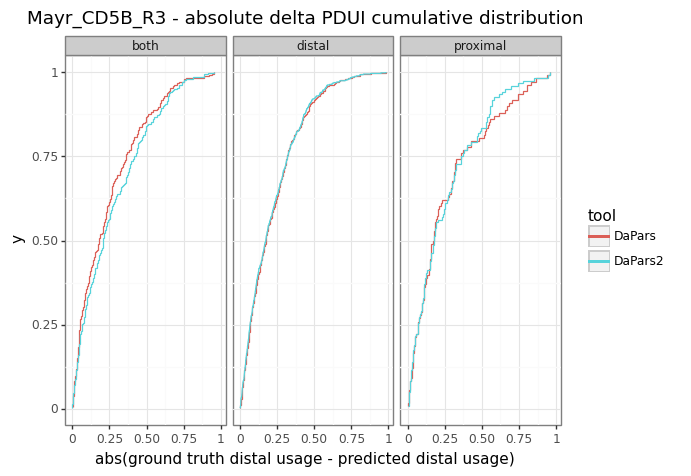

<ggplot: (8747343374833)>

In [69]:
from plotnine import ggplot, aes, labs, facet_wrap, geom_boxplot, geom_jitter, geom_violin
from plotnine.stats import stat_ecdf
from plotnine.themes import theme_bw

(ggplot(comb_gt_predn_abs_delta,
        aes(x="abs_delta_usage",
            color="tool")
       ) +
 facet_wrap("~ match_group") +
 stat_ecdf() +
 theme_bw() +
 labs(title="Mayr_CD5B_R3 - absolute delta PDUI cumulative distribution",
      x="abs(ground truth distal usage - predicted distal usage)")
)

Above, a shift to the left in the overall distribution would indicate a better performing tool. DaPars appears to perform slightly better than DaPars2 for the 'both sites match' group

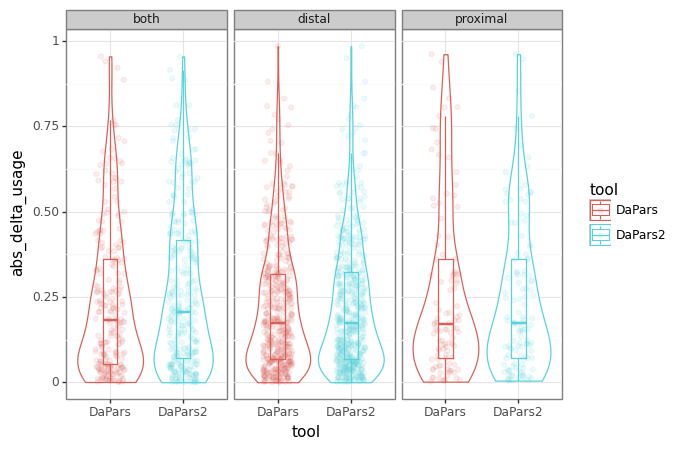

<ggplot: (8747343458211)>

In [68]:
(ggplot(comb_gt_predn_abs_delta,
        aes(y="abs_delta_usage",
            x="tool",
           colour="tool")
       ) +
 facet_wrap("~ match_group") +
 geom_violin() + 
 geom_boxplot(width=0.2, outlier_size=0, outlier_alpha=0) + 
 geom_jitter(alpha=0.1, width=0.2) + 
 theme_bw()
)

Also consider a plot of the number of unique terminal exons/PAS tested for each group? Potentially useful information to know how many events are being evaluated in each case.
